In [1]:
# Used hp_opt env
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras_tuner as kt, tensorflow as tf
import os, datetime, progressbar, sys
import tensorflow_probability as tfp

# import method
sys.path.insert(1, '/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/scripts/')
import not_sure_what_to_call_this as script

tfd = tfp.distributions

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

hp = HyperParameters()
plotlosses = PlotLossesKeras()

In [2]:
pwd

'/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/notebooks'

Load toy model. The image pixel sizes are small. Only 32x32 so that I can get quick results.

In [3]:
# load data
toy_model = np.load('toy_models_32x32.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']

outputdir = "./"
idx = "32"
project_name='toy_model_tuner_noise_{}'.format(idx)
HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

In [4]:
# Normalizing the data
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

# load divegence normalization function
kl_divergence_function = script.kl_divergence_normalization_term(TRAINING_DATA=training_data)

training (8000, 32, 32, 1)
validation (2000, 32, 32, 1)


In [5]:
# make custom functions callable with keras
keras.utils.get_custom_objects().update({#'Mean_Squared_over_true_Error':script.custom_loss.Mean_Squared_over_true_Error,
                                         'neg_log_likelihood': script.custom_loss.neg_log_likelihood, 
                                         'kl_divergence':script.custom_loss.kl_divergence,
                                         'elbo':script.custom_loss.elbo})


In [6]:
#build noisy data
noisy_X_train, noisy_X_test = script.add_noise_to_data(variances = [.01, .001, .0001], 
                                                       X_train = X_train, 
                                                       X_test = X_test,
                                                      )

Variance  0.01
Reading in data ...
Append data ...
Variance  0.001
Reading in data ...
Append data ...
Variance  0.0001
Reading in data ...
Append data ...
Training data shape: (3, 8000, 32, 32, 1)
Test data shape: (3, 2000, 32, 32, 1)


Selected a single image in the training dataset. The ionized pixels are labels 0 and all other pixels have non-zero values.

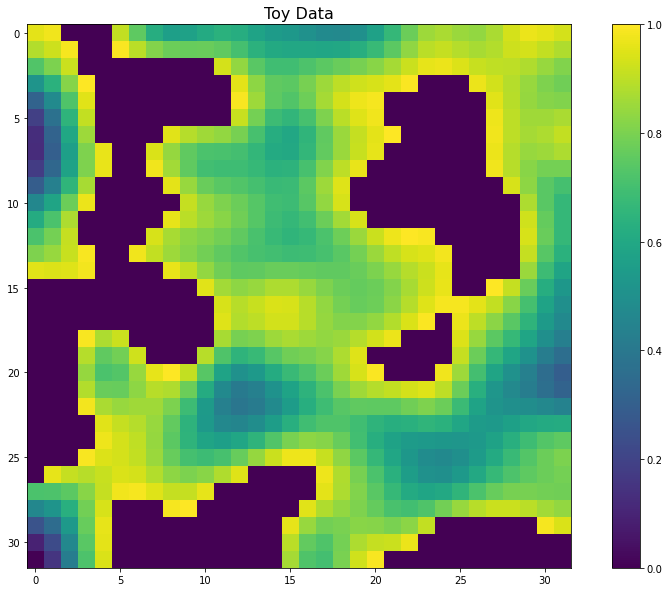

In [7]:
# Original data
plt.figure(figsize=(15, 10))
plt.imshow(X_train[0,:,:,0])
plt.title("Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

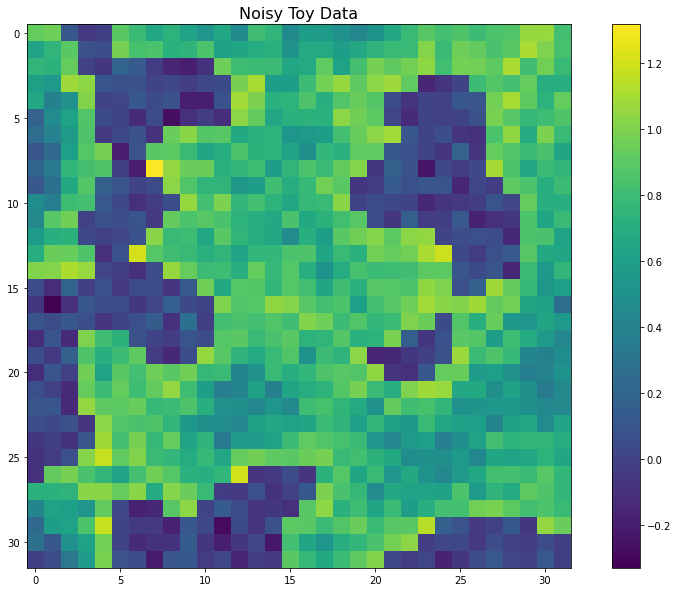

In [8]:
# Variance 0.01
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[0][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

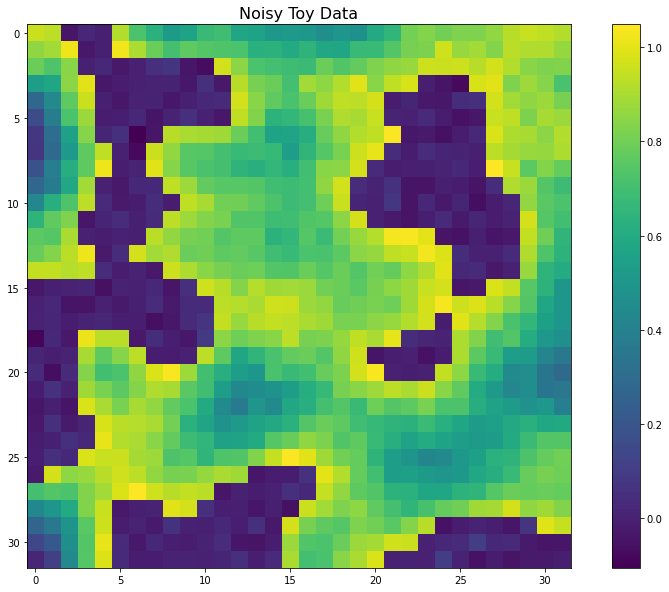

In [9]:
# Variance 0.001
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[1][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

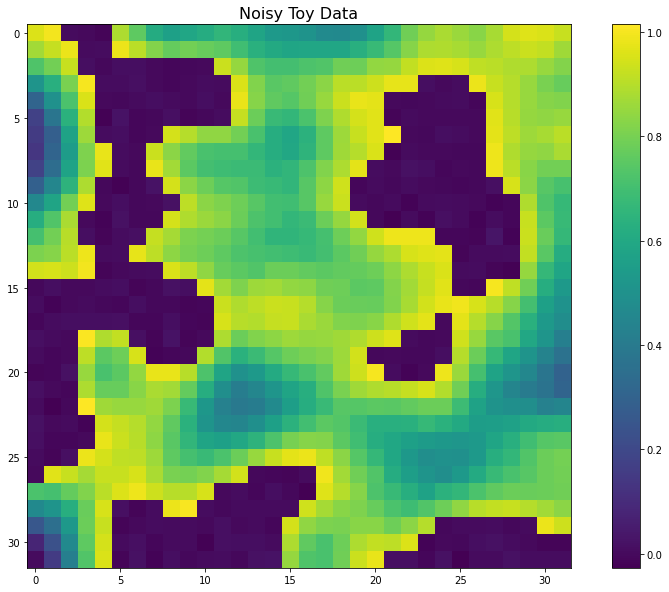

In [10]:
# Variance 0.0001
plt.figure(figsize=(15, 10))
plt.imshow(noisy_X_train[2][0,:,:,0])
plt.title("Noisy Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

Looking at the distribution of the labeled pixel values. It should be uniform because we want to sample the space evenly. 

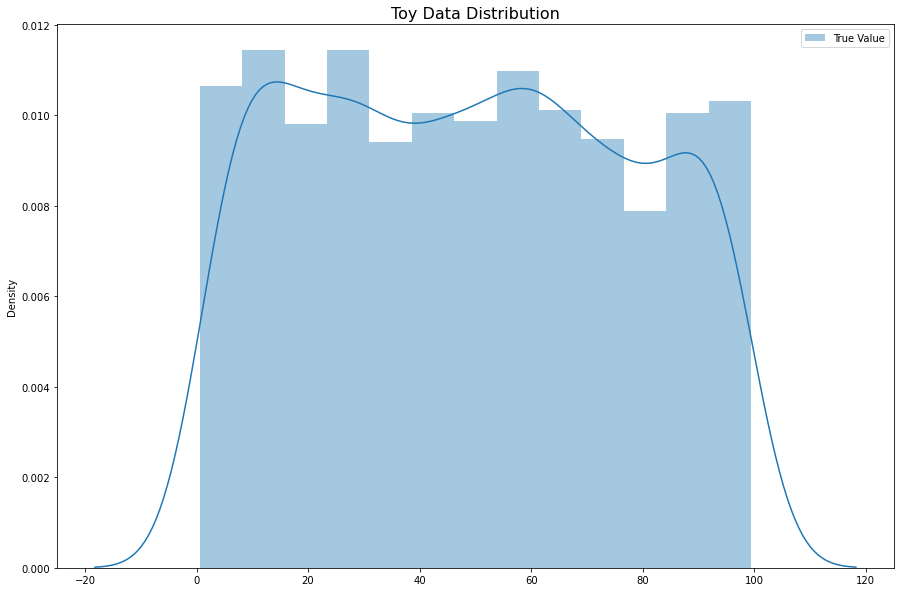

In [11]:
plt.figure(figsize=(15, 10))
sns.distplot(y_test,label="True Value")
plt.title("Toy Data Distribution",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

# Train Model Using Deterministic Loss Function

Build a simple probiblistic model and train it using deterministic loss functins to see which ne performs well. It's clear from the one-to-one plots that the all of the the loss types except for **loss_type: Mean_Squared_over_true_Error** work well forr this model. In general **mse** performs the best with other CNN architectures (not demonstrated in this notebook). The cool things is that for this particular dataset size (32x32) we acheive good results with few training steps (only 5).  

I used kera-tuner to randomly search the turning space. Unfortunately it seems a s though I cannot trust which model says is the best model because although in most cases the model with the lowest validation loss is the best model... that's not true here. The best model doesn't have the smallest validation loss. So this isn't a good way of finding the best model... But it is an easy way to train multiple models... So yeah that's why I'm using it.

In [7]:
def model1_dloss(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
    
    

## Noise 1.1

### Train Model Using Deterministic Loss Function

In [13]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

# Random searrch through choices
tuner_models = script.random_search(model= model1_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= noisy_X_train[0], 
                                    y_train= y_train,
                                    X_test= noisy_X_test[0], 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 3 Complete [00h 05m 35s]
val_loss: 1.6197195053100586

Best val_loss So Far: 1.6197195053100586
Total elapsed time: 00h 16m 37s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_noise_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.6197195053100586
Trial summary
Hyperparameters:
loss_type: mse
Score: 2.7123117446899414
Trial summary
Hyperparameters:
loss_type: mape
Score: 5.074198246002197
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 16)        304      

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [14]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=noisy_X_test[0])

(2000, 32, 32, 1)
(4, 2000)


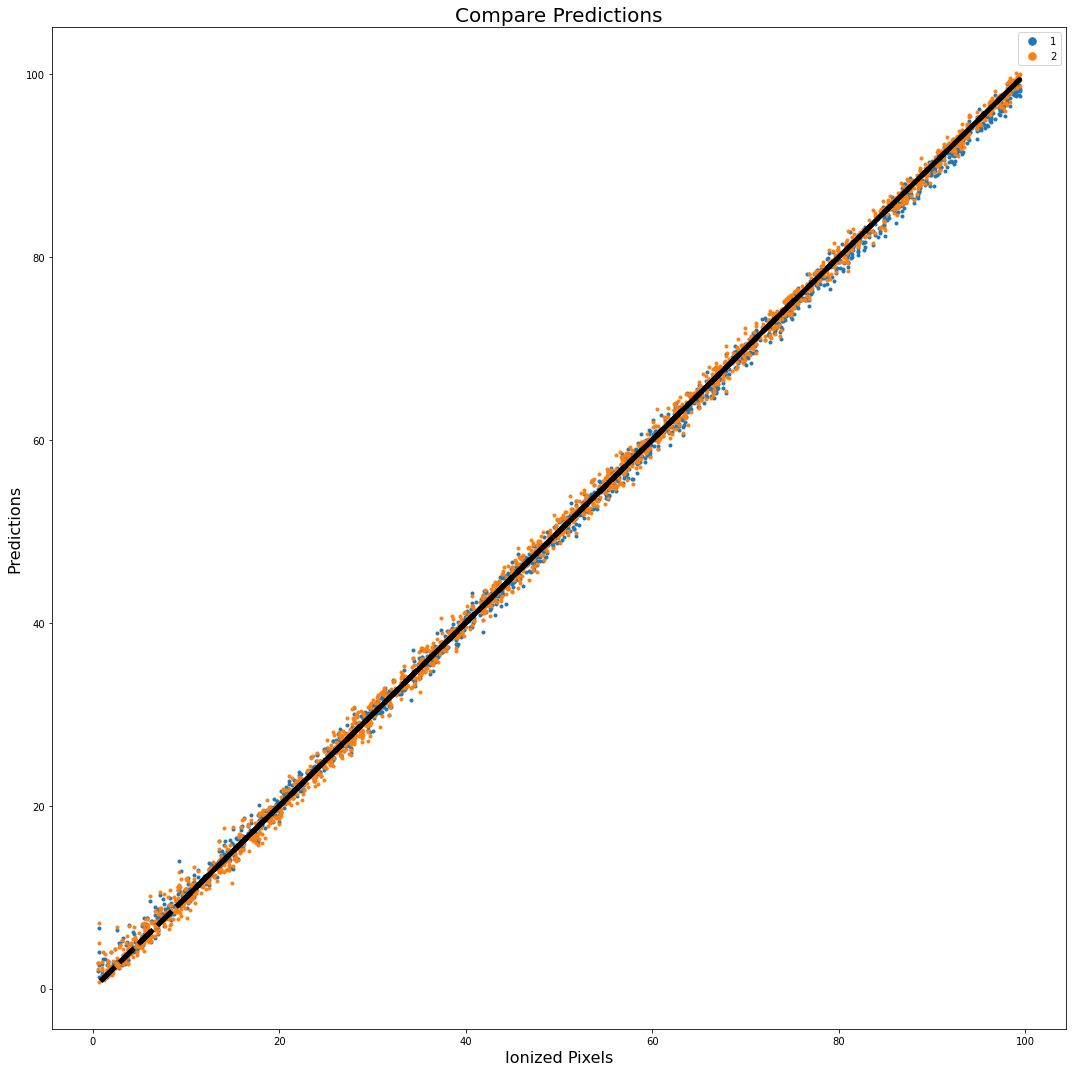

In [15]:
script.plot_one_to_one_pred(tuner_models= tuner_models[1:], y_test= y_test, predictions=predictions[1:,:])

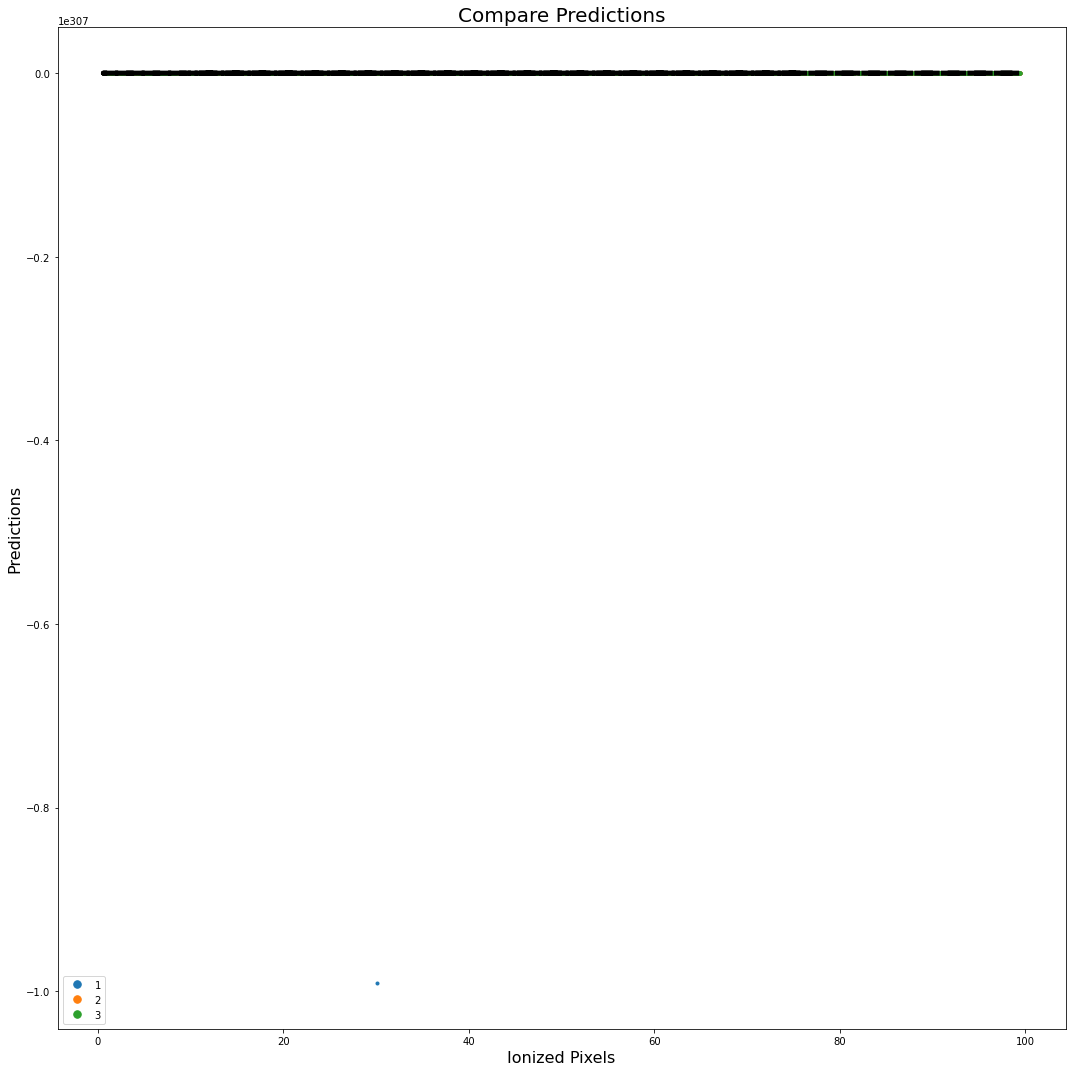

In [16]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

In [17]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[1], X_test=noisy_X_test[0])

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


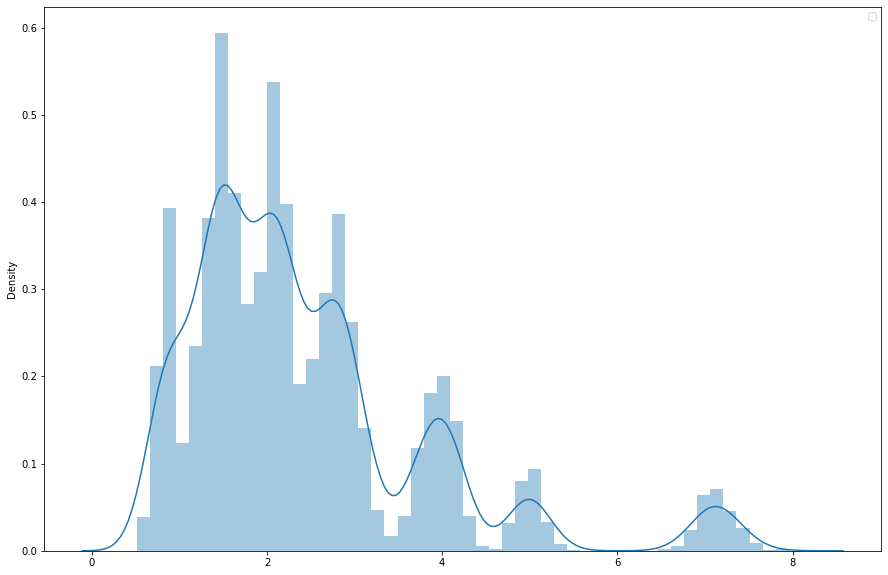

In [18]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

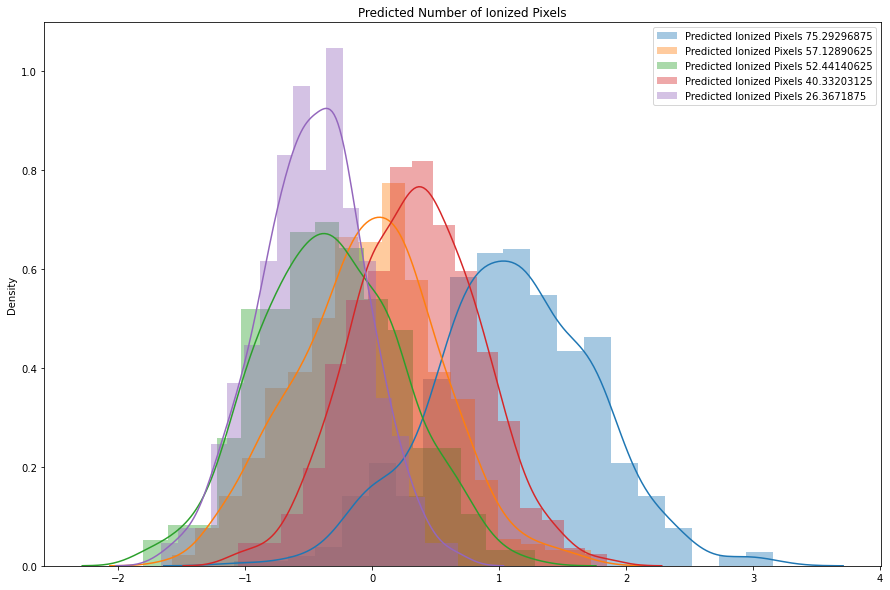

In [19]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

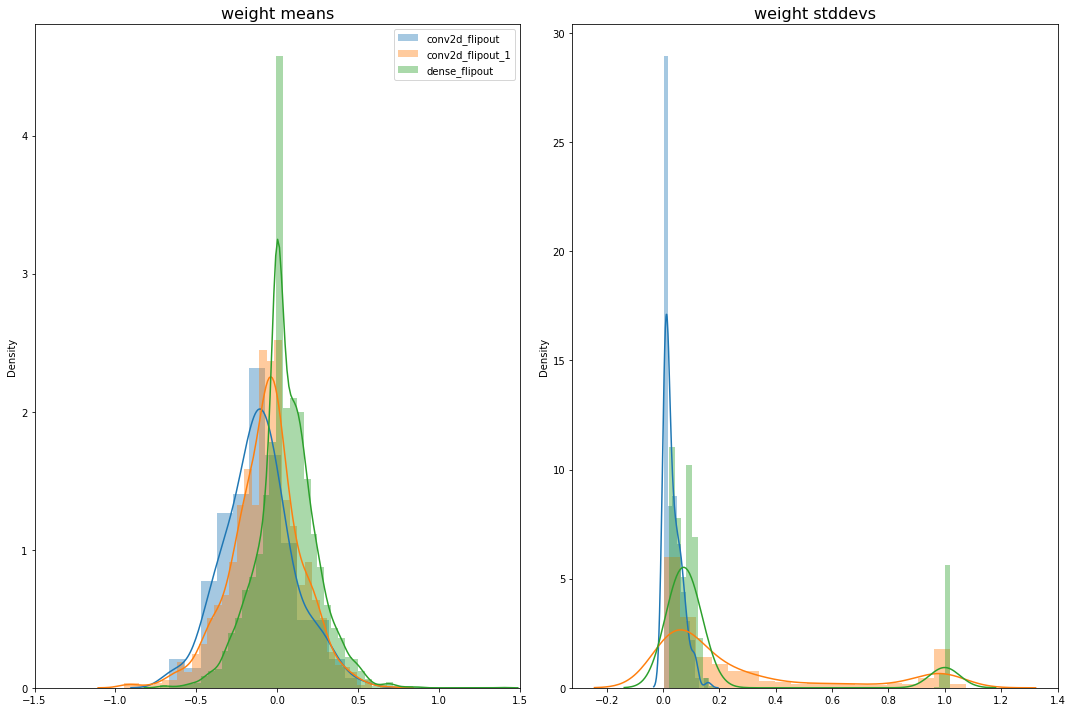

In [20]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-1])

### Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

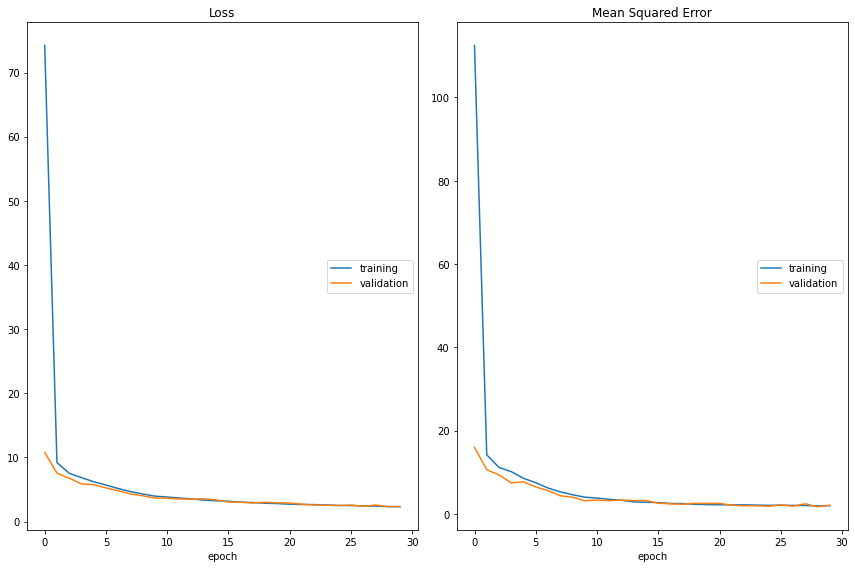

Loss
	training         	 (min:    2.303, max:   74.217, cur:    2.303)
	validation       	 (min:    2.317, max:   10.773, cur:    2.336)
Mean Squared Error
	training         	 (min:    1.937, max:  112.481, cur:    1.963)
	validation       	 (min:    1.726, max:   15.982, cur:    2.099)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 16)        304       
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 28, 28, 8)         2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 12545     
_________________________________________________________________
distribution_lambda (Distrib m

In [21]:
model = script.model1_ploss(X_train=noisy_X_train[0], y_train=y_train, 
                    X_test=noisy_X_test[0], y_test=y_test, nx=nx, ny=ny,
                    kl_divergence_function=kl_divergence_function,
                    epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE)

### Monte Carlo 

In [22]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=noisy_X_test[0])

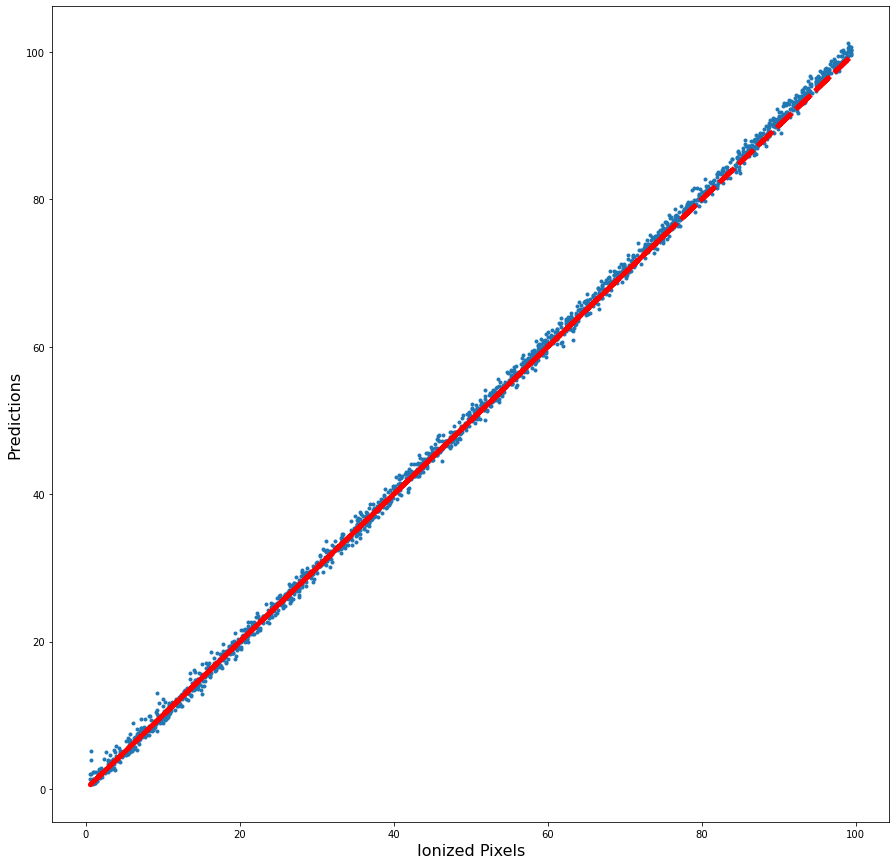

In [23]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

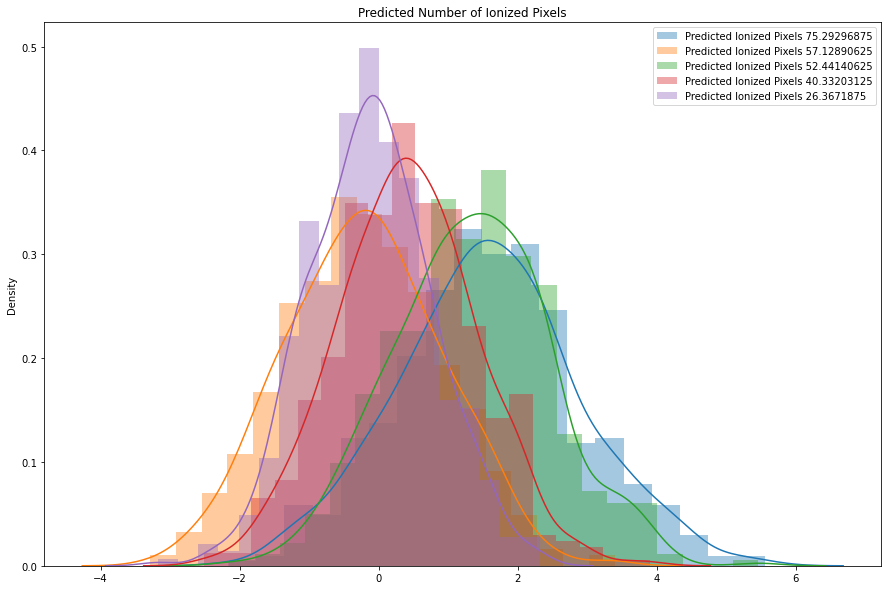

In [24]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


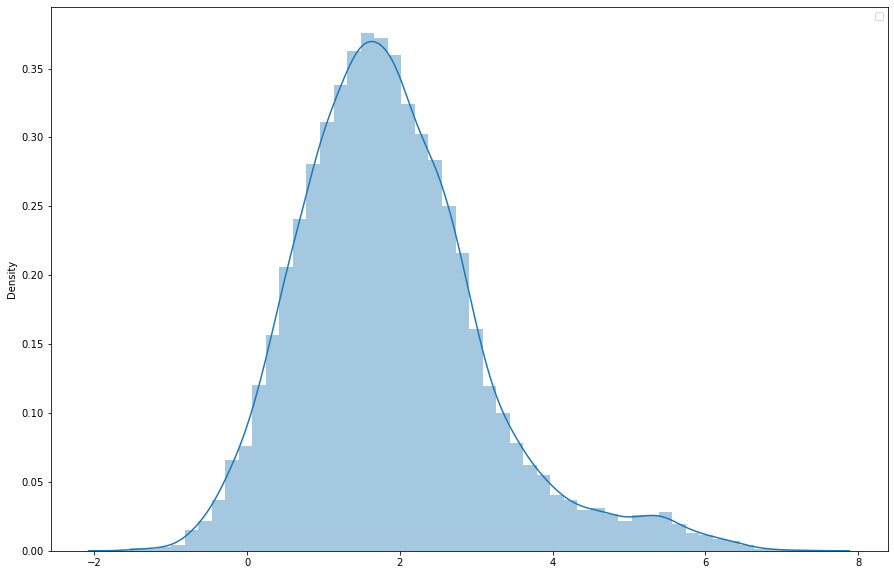

In [25]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


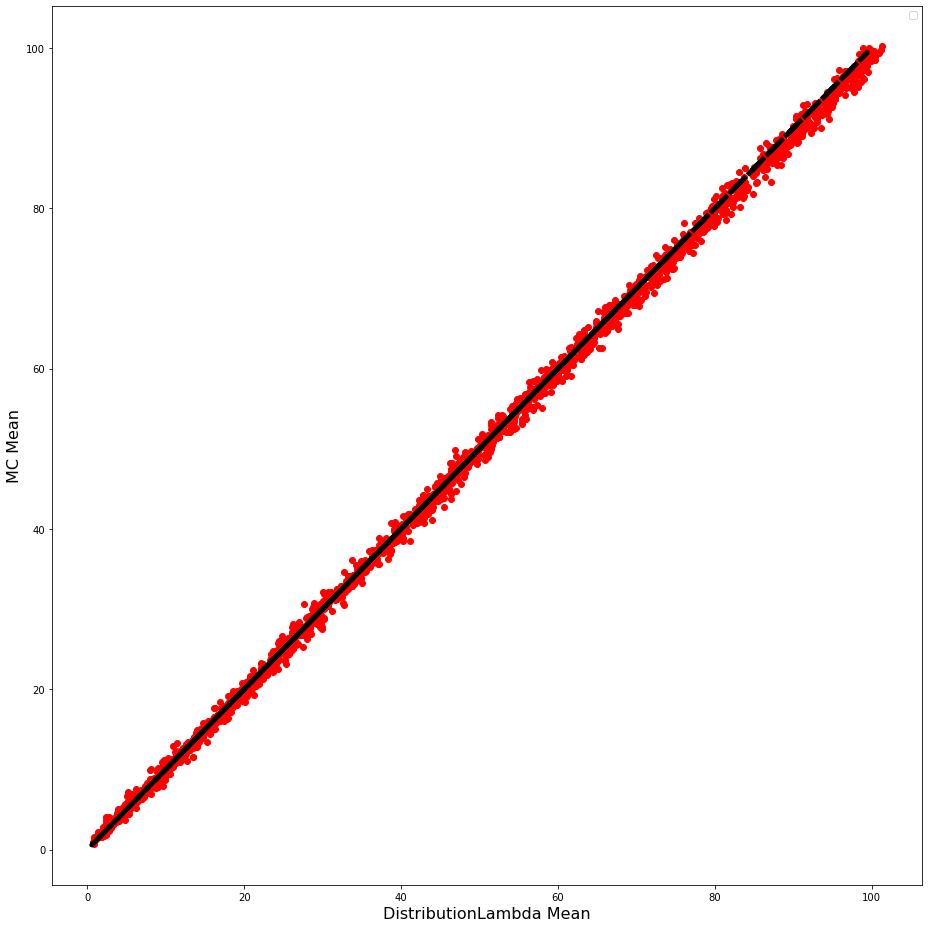

In [26]:
script.plot_compare_pred_values(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


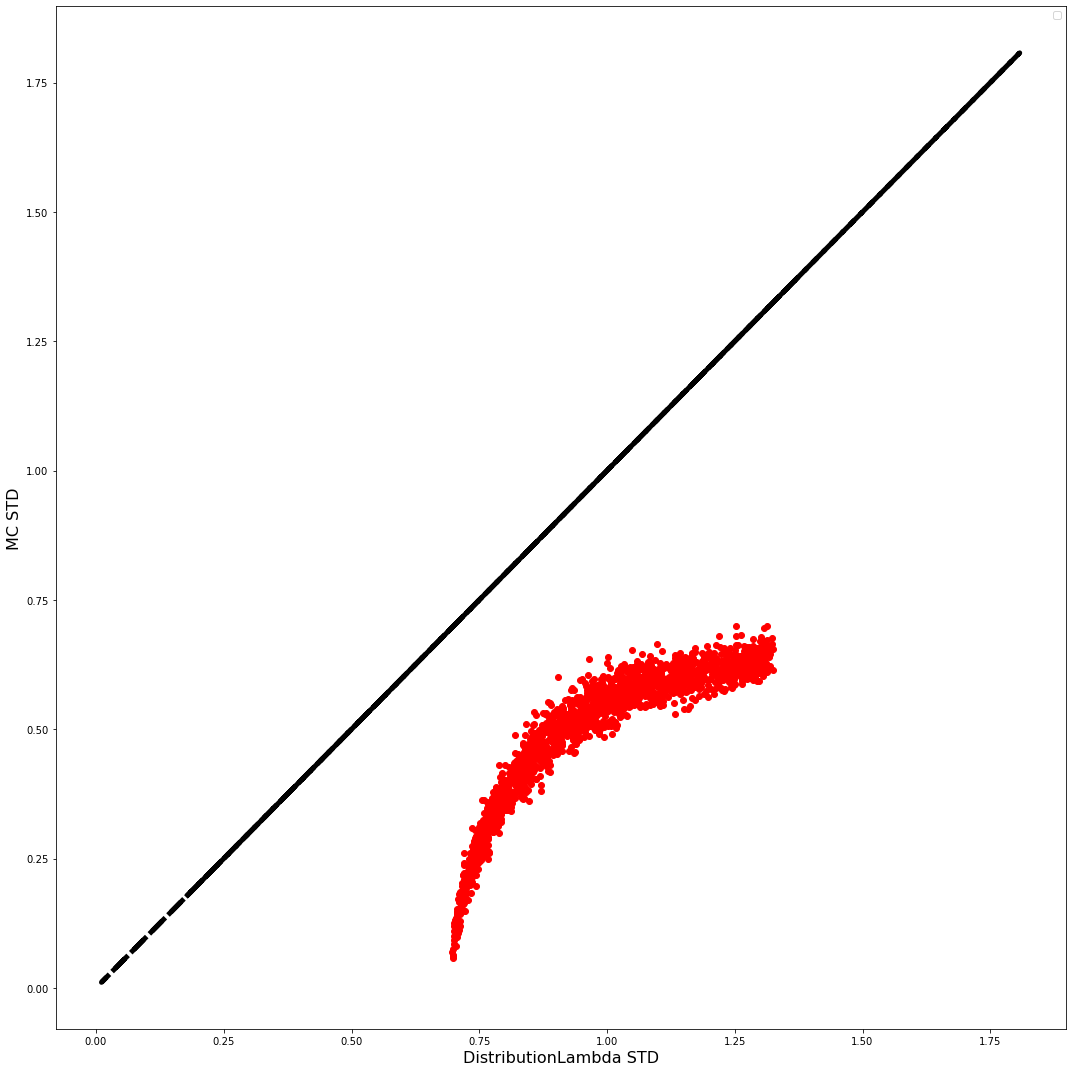

In [27]:
script.plot_compare_STDs(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

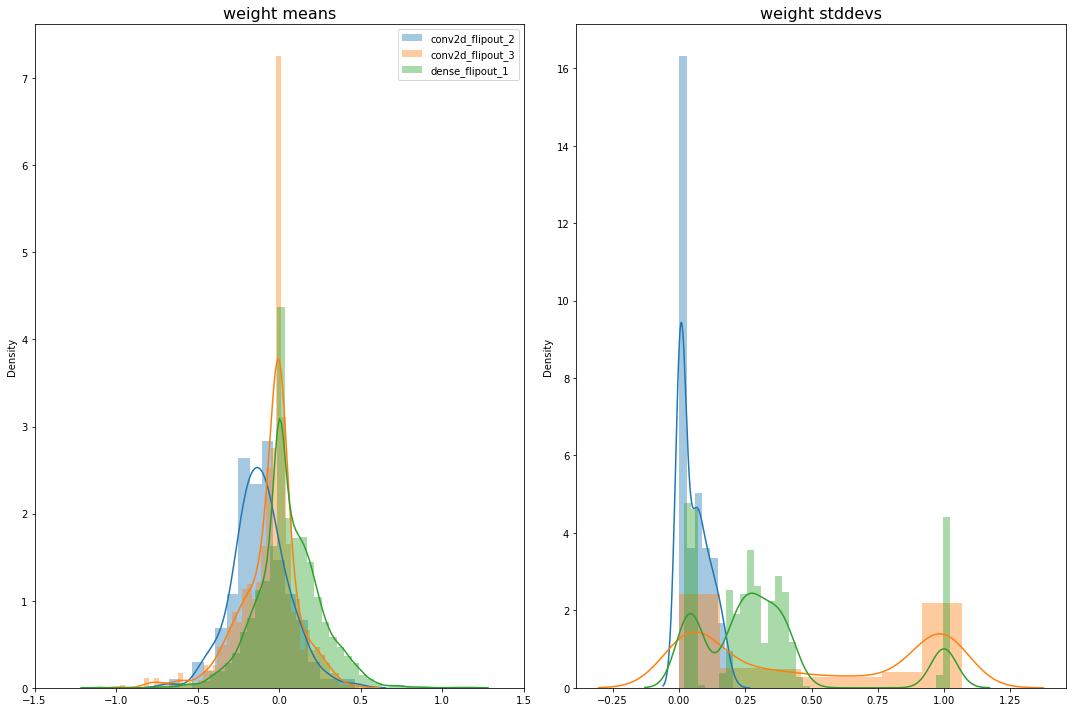

In [28]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [29]:
yhat = model(noisy_X_test[0]) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

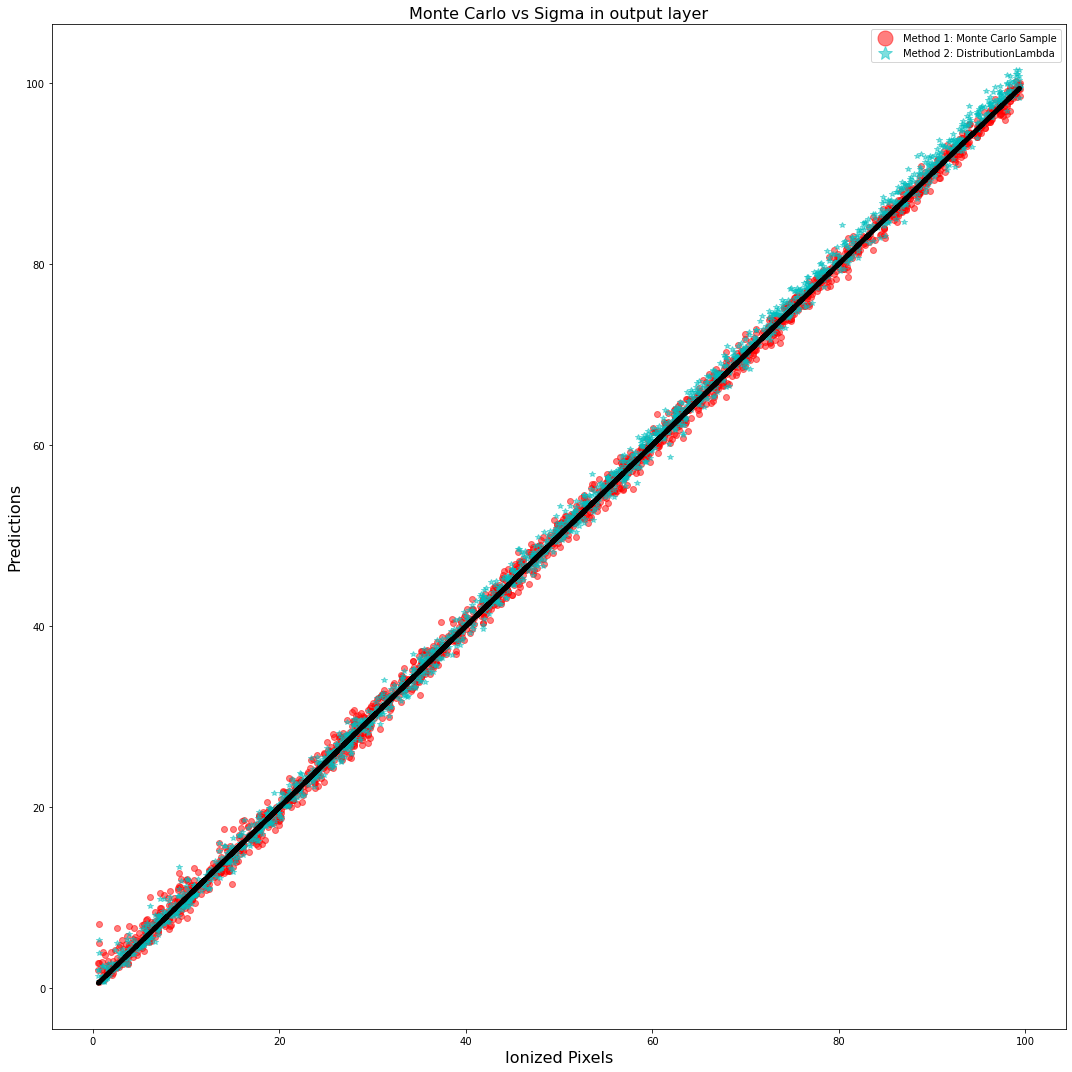

In [30]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

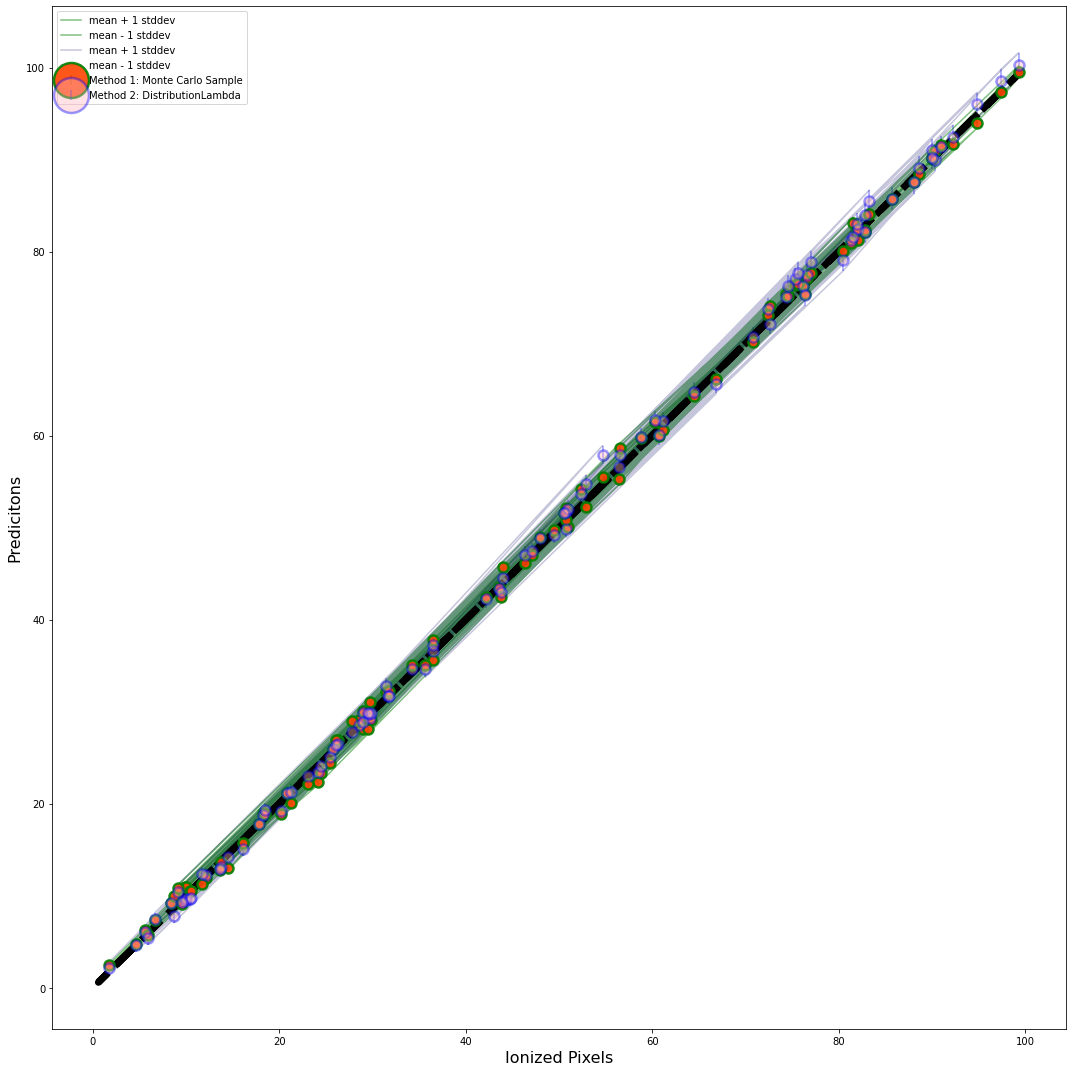

In [31]:
script.plot_error1(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

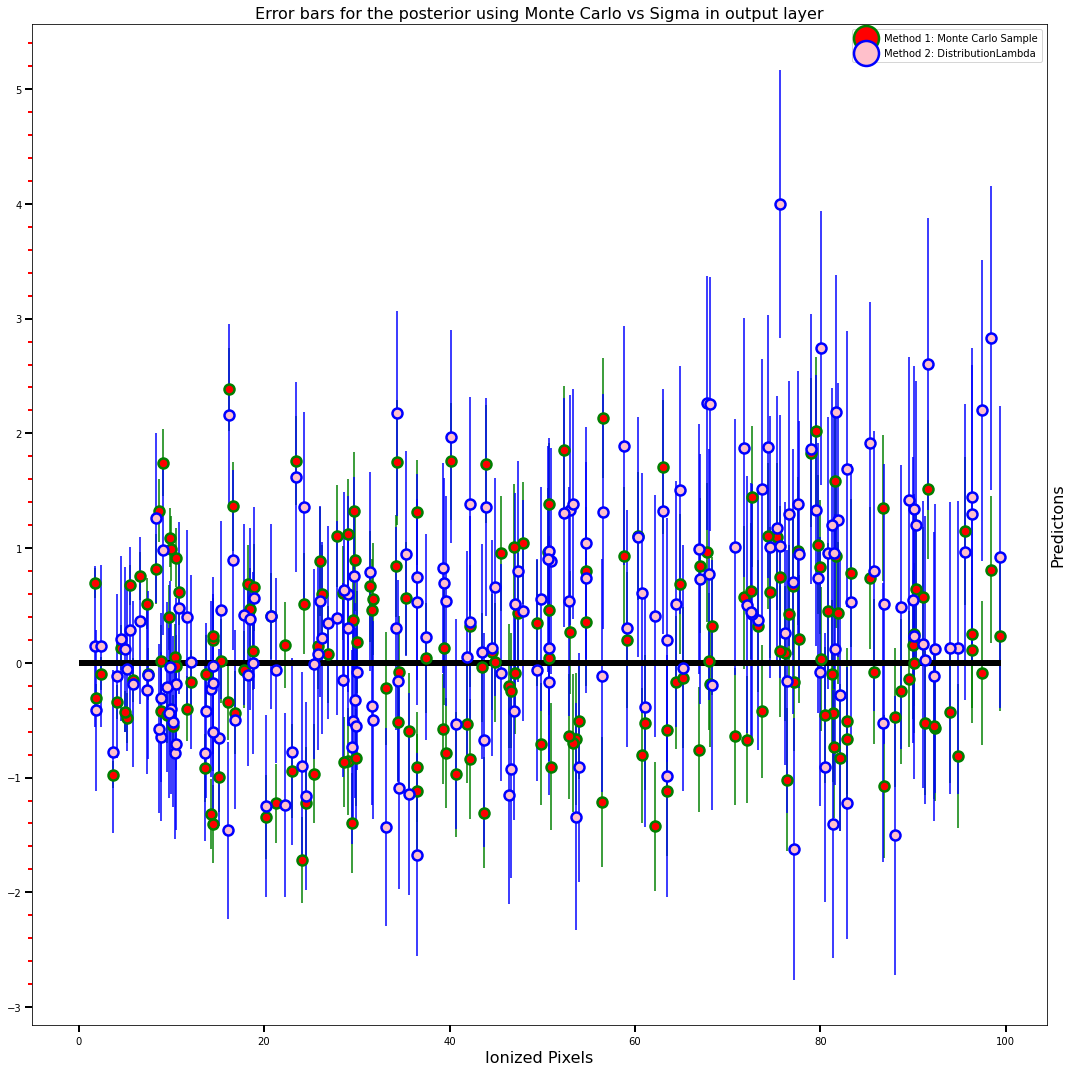

In [32]:
script.plot_error2(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

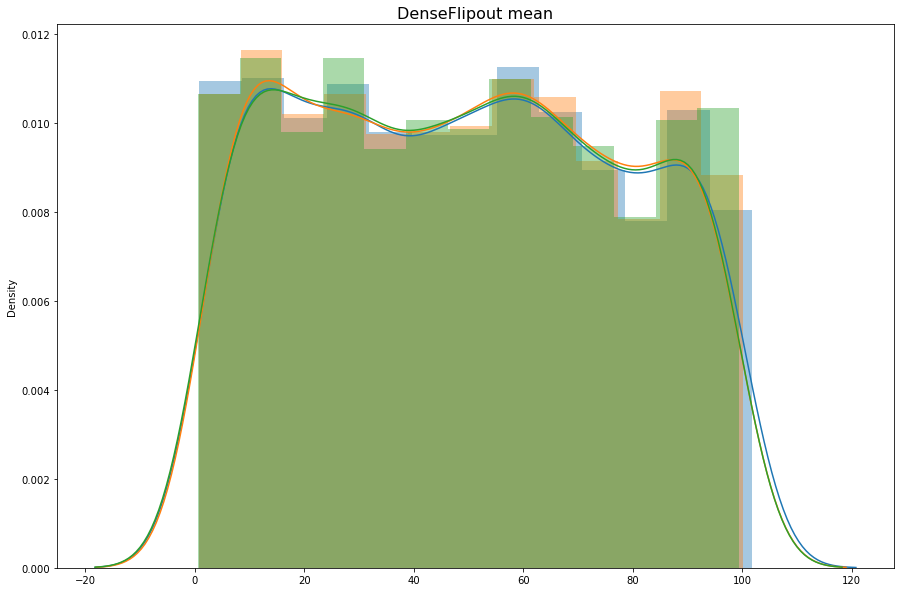

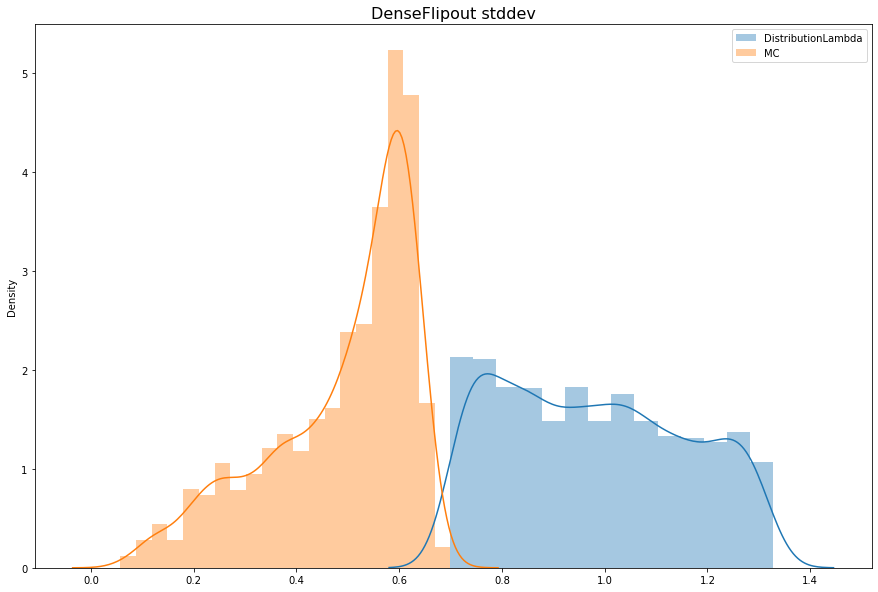

In [33]:
script.plot_distribution_mean_std(yhat=model(noisy_X_test[0]), predictions= pred, y_test= y_test)

## Noise 1.2

### Train Model Using Deterministic Loss Function

In [34]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

# Random searrch through choices
tuner_models = script.random_search(model= model1_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= noisy_X_train[1], 
                                    y_train= y_train,
                                    X_test= noisy_X_test[1], 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 3 Complete [00h 05m 11s]
val_loss: 1.53993821144104

Best val_loss So Far: 1.53993821144104
Total elapsed time: 00h 16m 39s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_noise_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.53993821144104
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.8748997449874878
Trial summary
Hyperparameters:
loss_type: mape
Score: 3.8059635162353516
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 16)        304       
___

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [35]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=noisy_X_test[1])

(2000, 32, 32, 1)
(4, 2000)


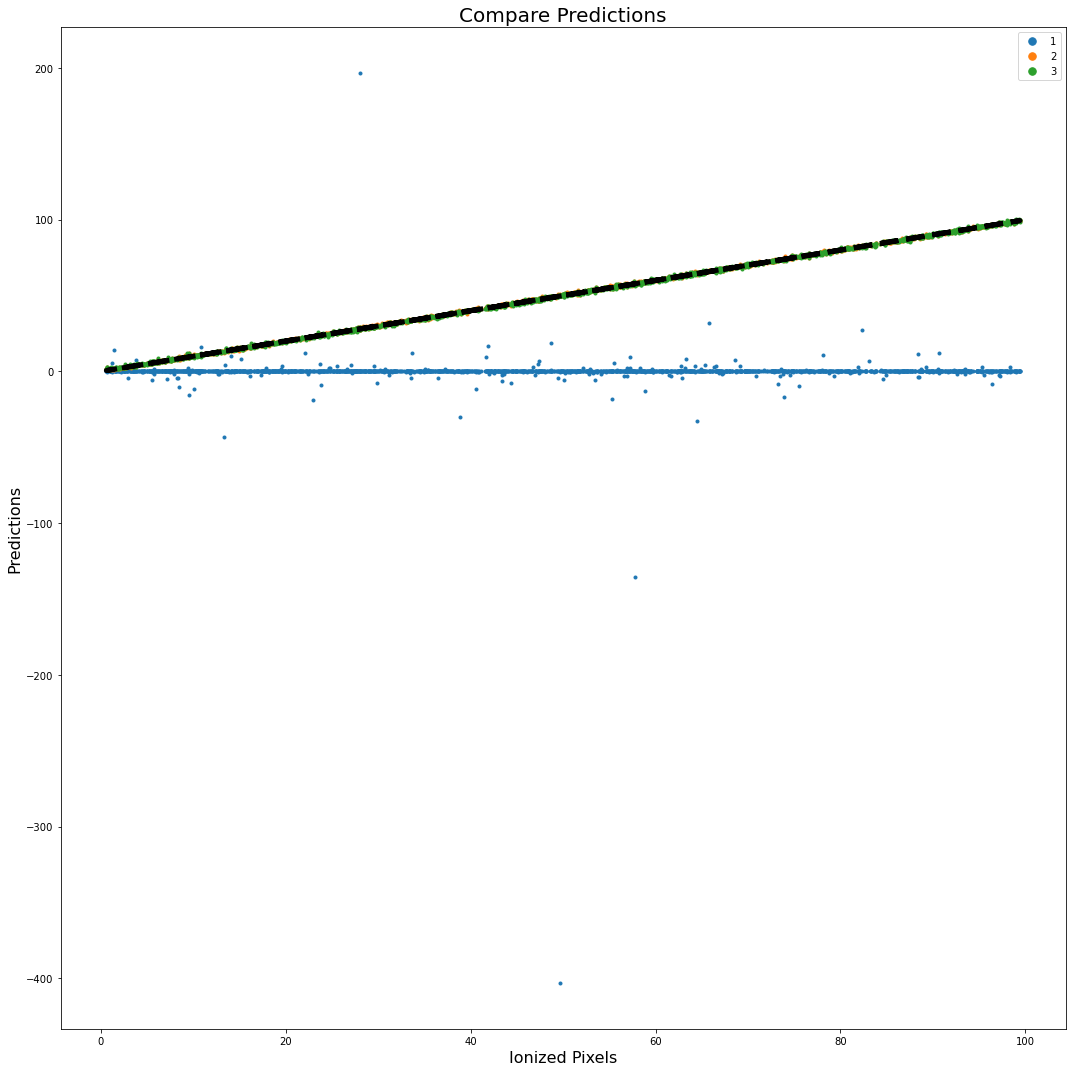

In [36]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

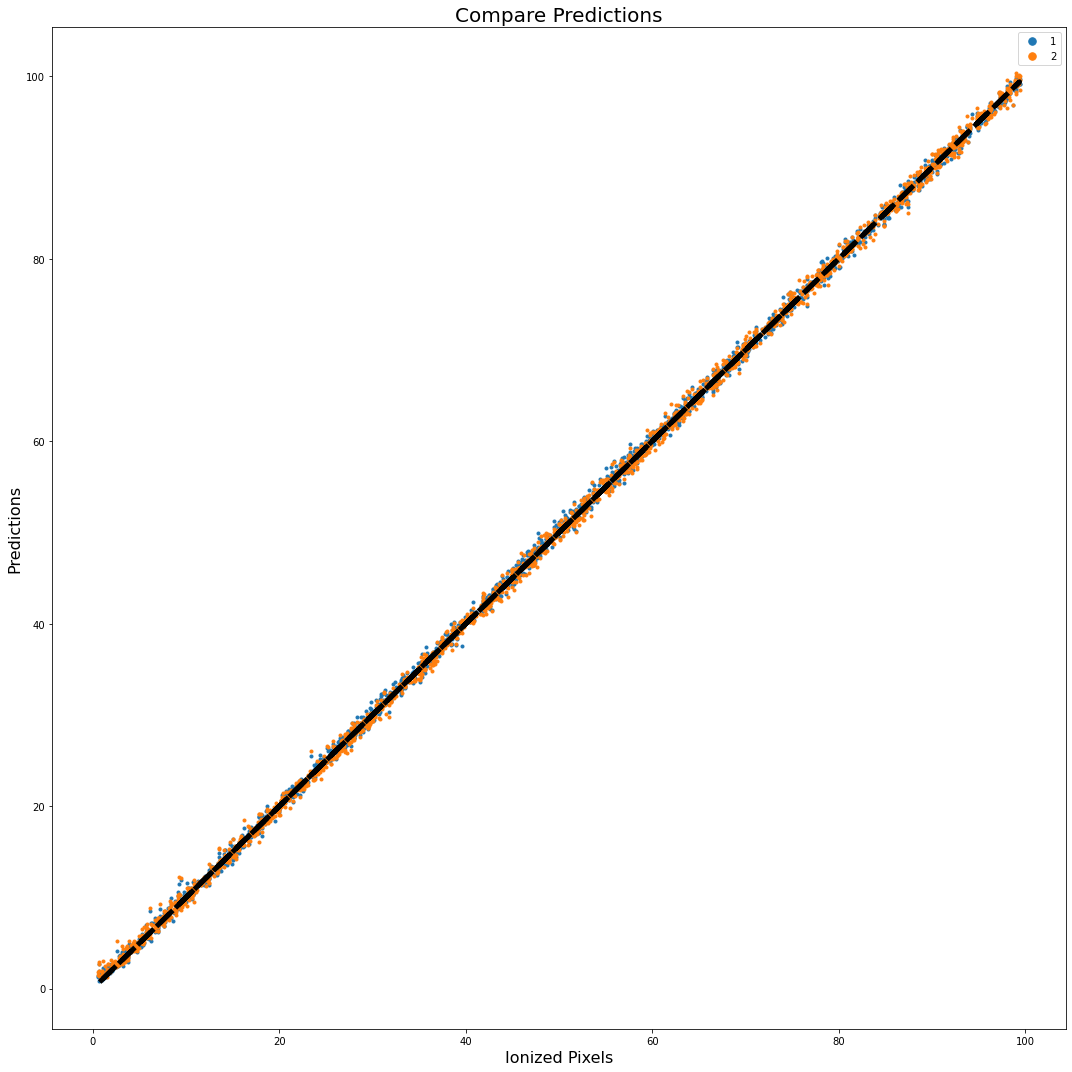

In [37]:
script.plot_one_to_one_pred(tuner_models= tuner_models[1:], y_test= y_test, predictions=predictions[1:,:])

In [38]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[1], X_test=noisy_X_test[1])

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


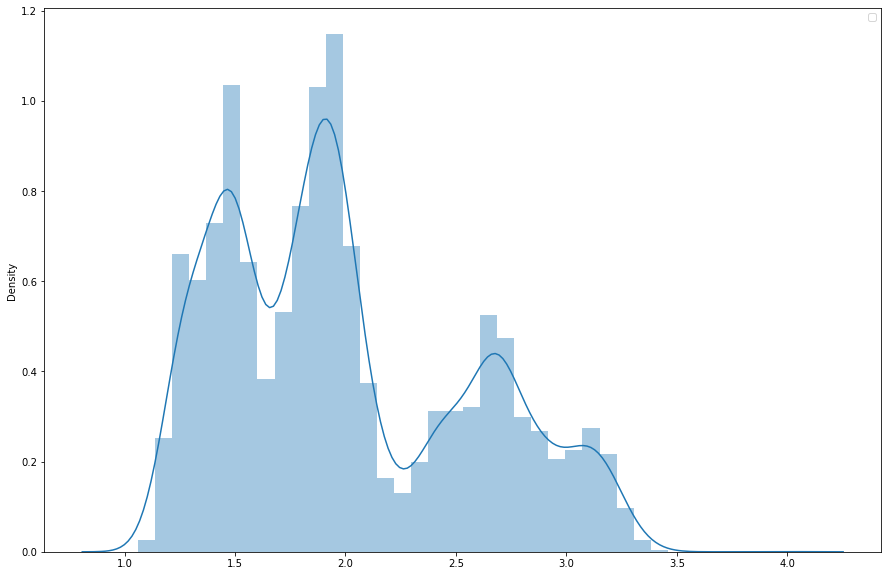

In [39]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

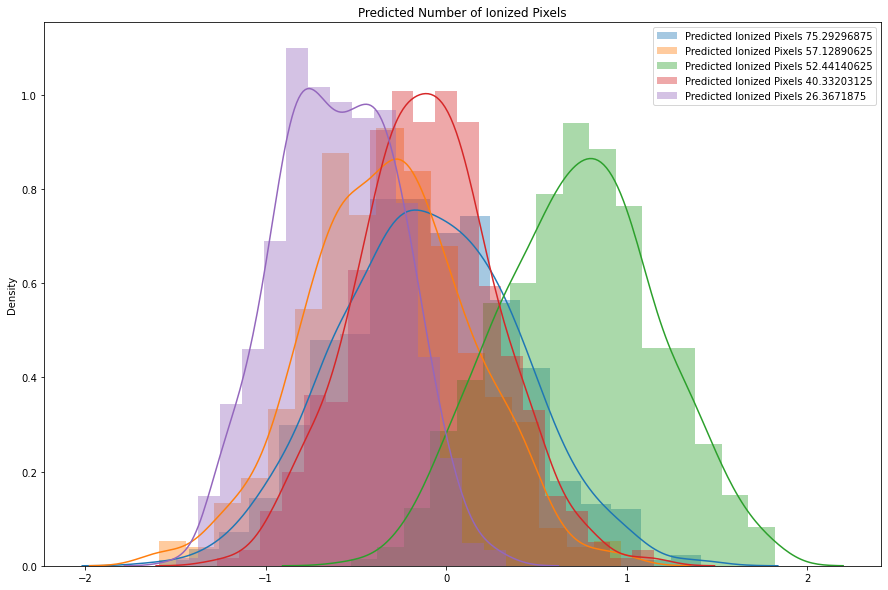

In [40]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

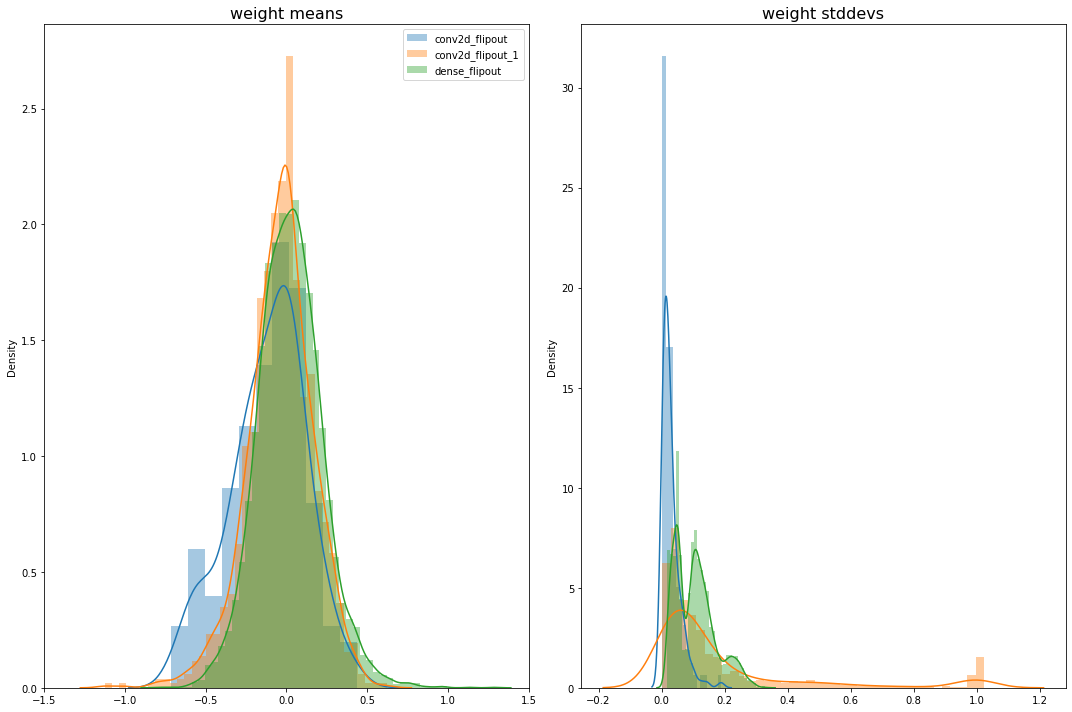

In [41]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-1])

### Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

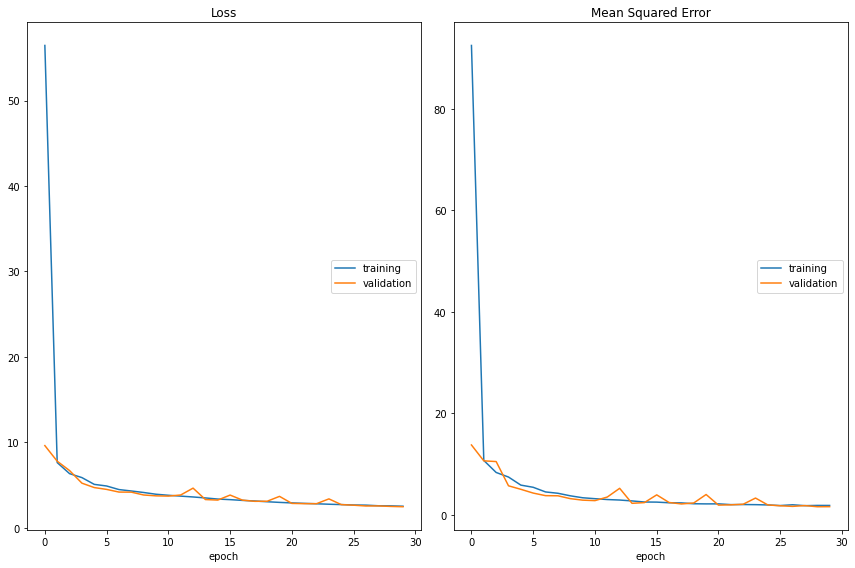

Loss
	training         	 (min:    2.514, max:   56.442, cur:    2.514)
	validation       	 (min:    2.454, max:    9.608, cur:    2.454)
Mean Squared Error
	training         	 (min:    1.831, max:   92.520, cur:    1.874)
	validation       	 (min:    1.620, max:   13.792, cur:    1.635)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 16)        304       
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 28, 28, 8)         2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 12545     
_________________________________________________________________
distribution_lambda (Distrib m

In [42]:
model = script.model1_ploss(X_train=noisy_X_train[1], y_train=y_train, 
                    X_test=noisy_X_test[1], y_test=y_test, nx=nx, ny=ny,
                    kl_divergence_function=kl_divergence_function,
                    epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE)

### Monte Carlo 

In [43]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=noisy_X_test[1])

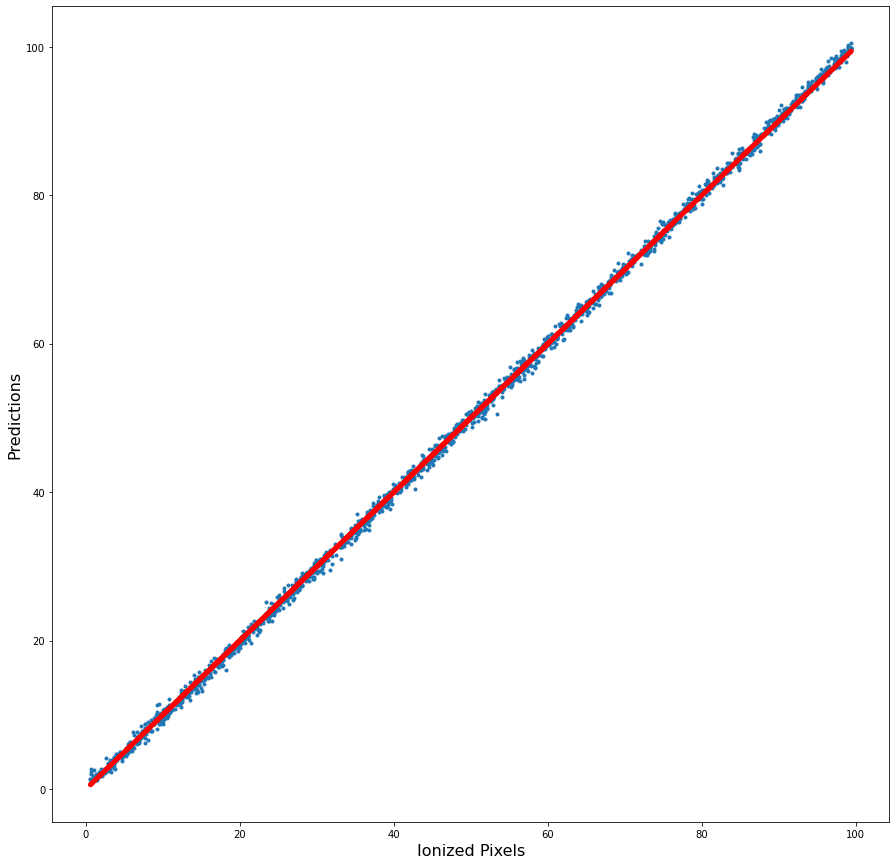

In [44]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

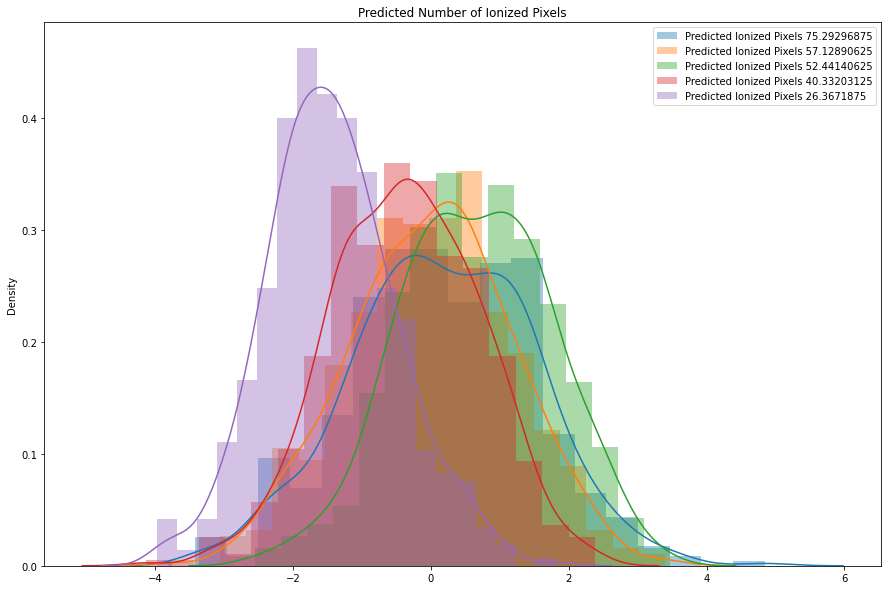

In [45]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


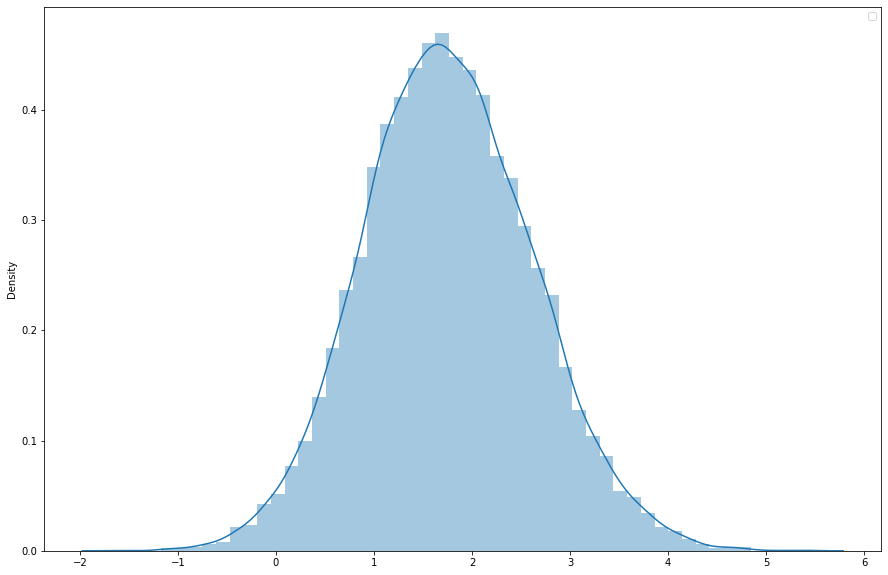

In [46]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


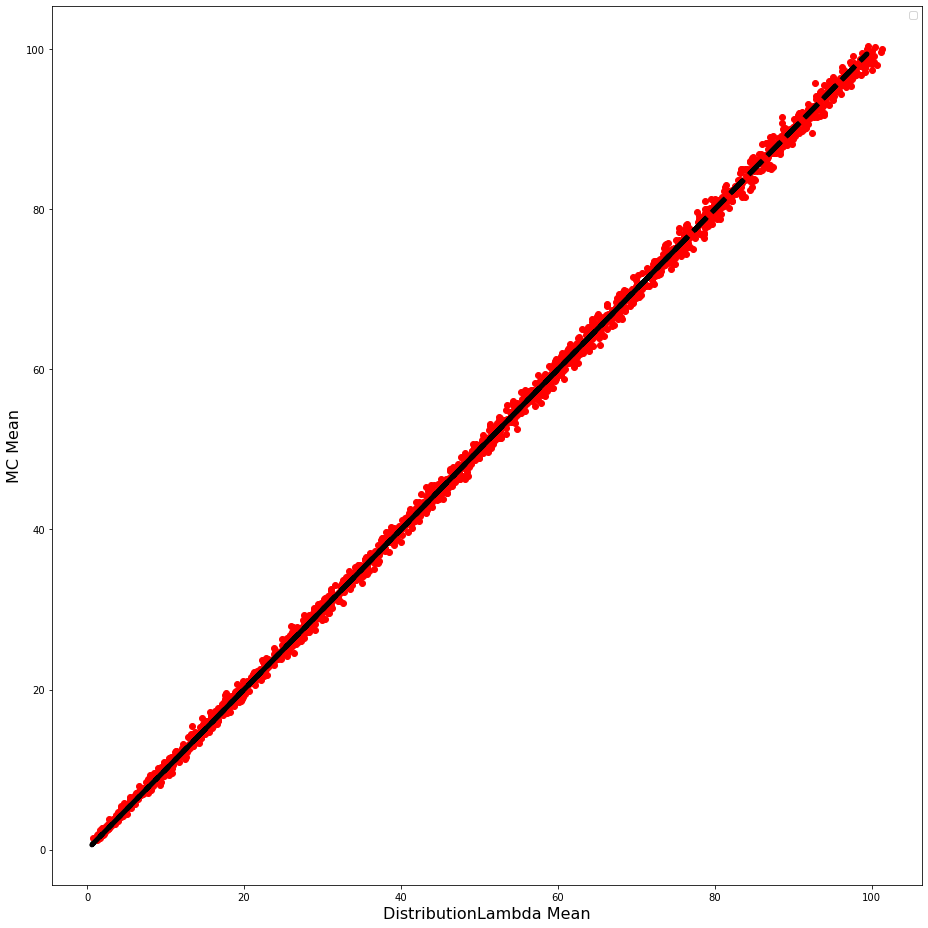

In [47]:
script.plot_compare_pred_values(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


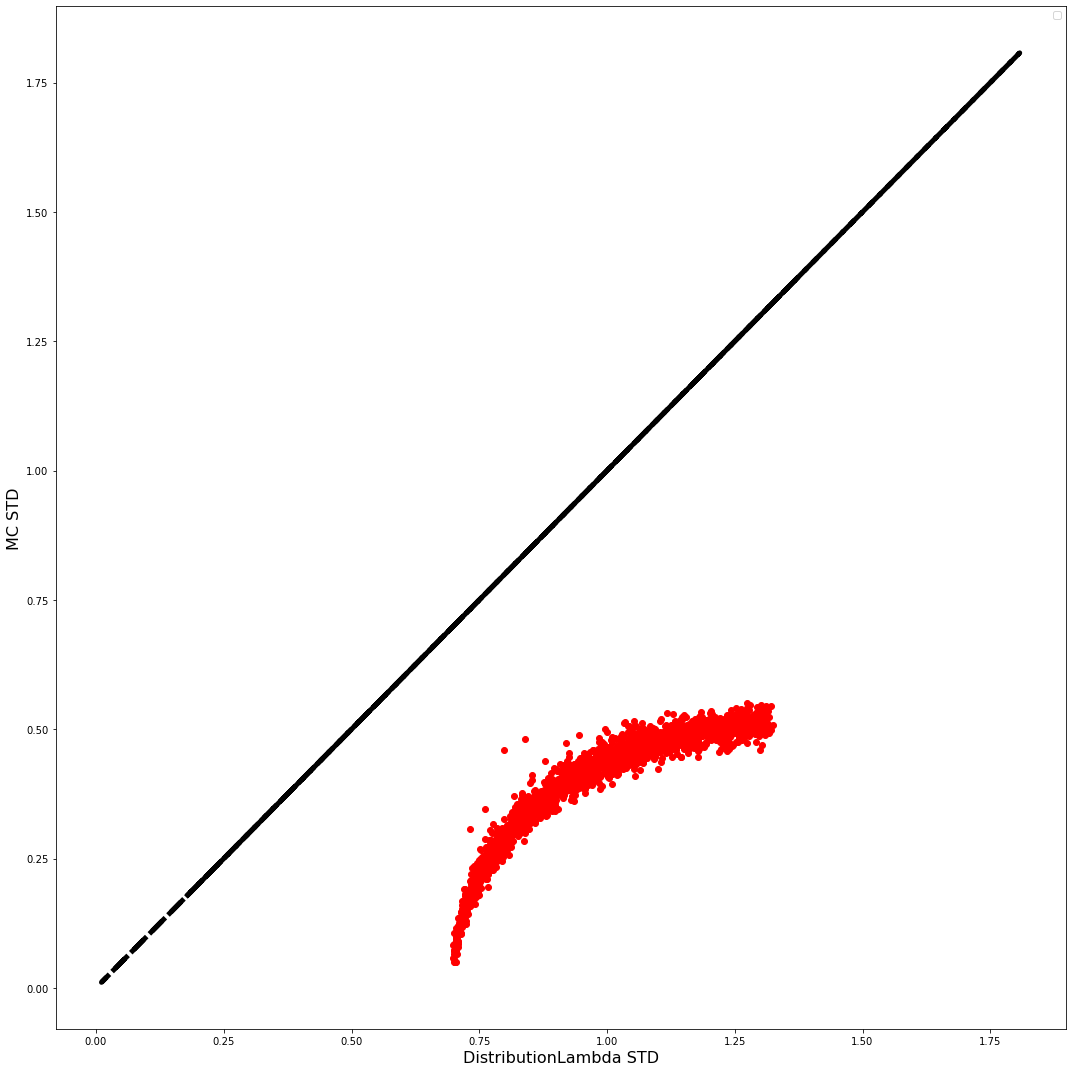

In [48]:
script.plot_compare_STDs(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

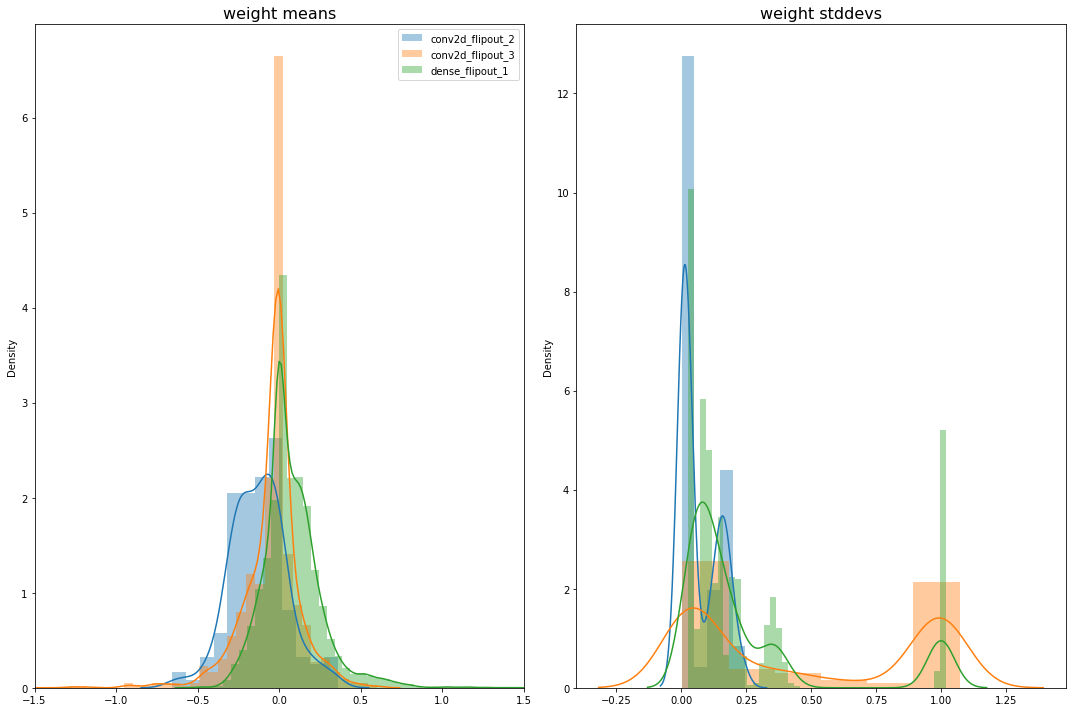

In [49]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [50]:
yhat = model(noisy_X_test[1]) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

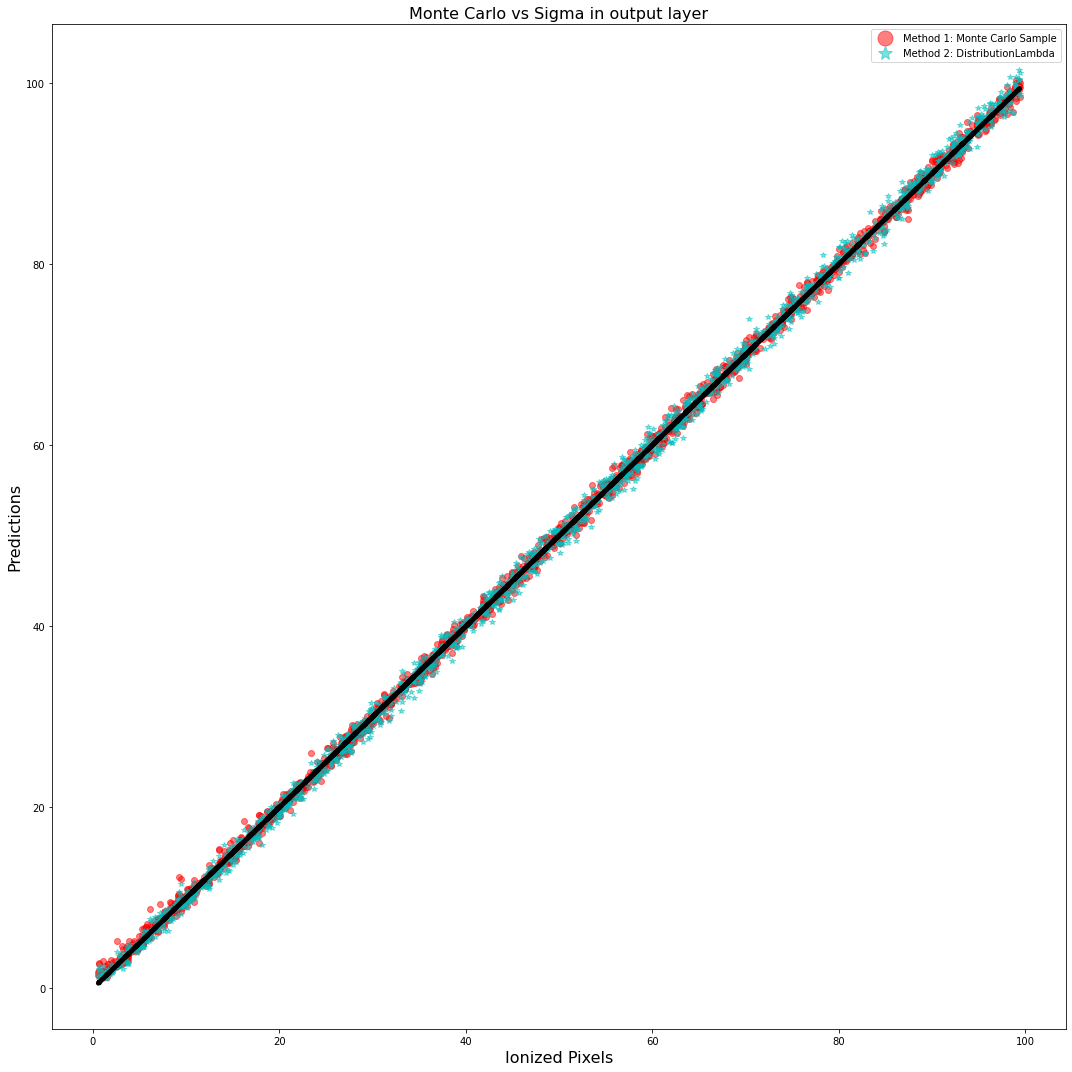

In [51]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

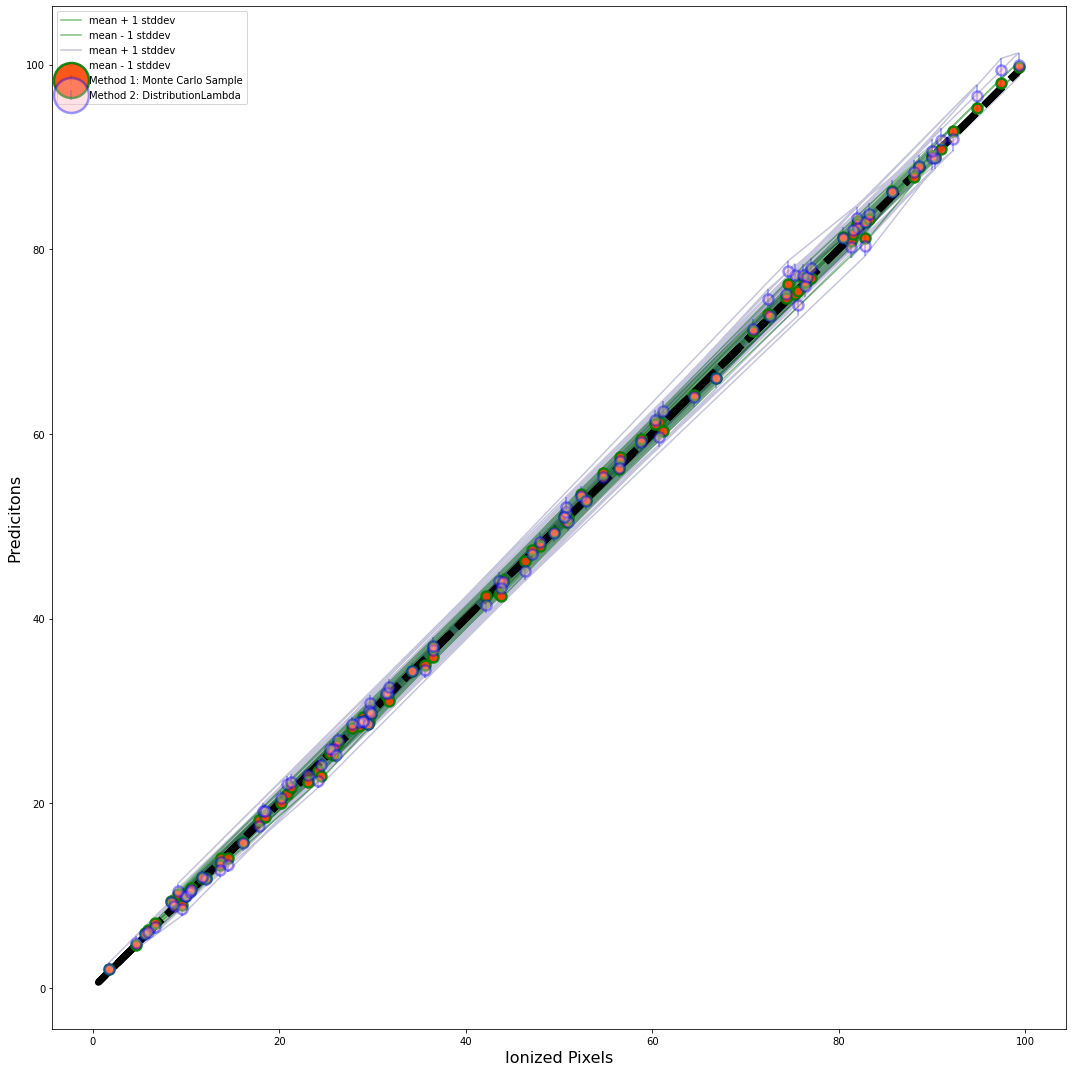

In [52]:
script.plot_error1(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

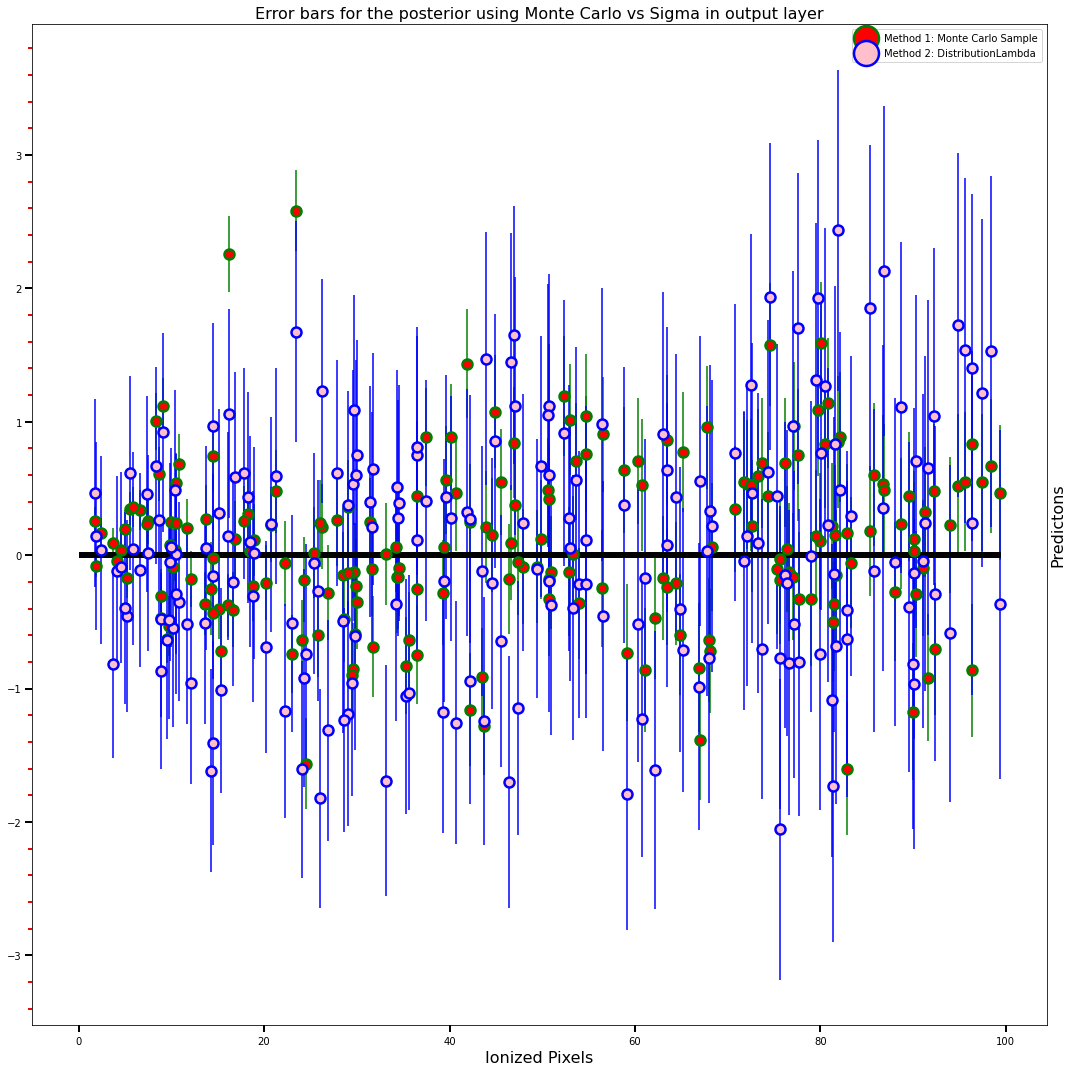

In [53]:
script.plot_error2(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

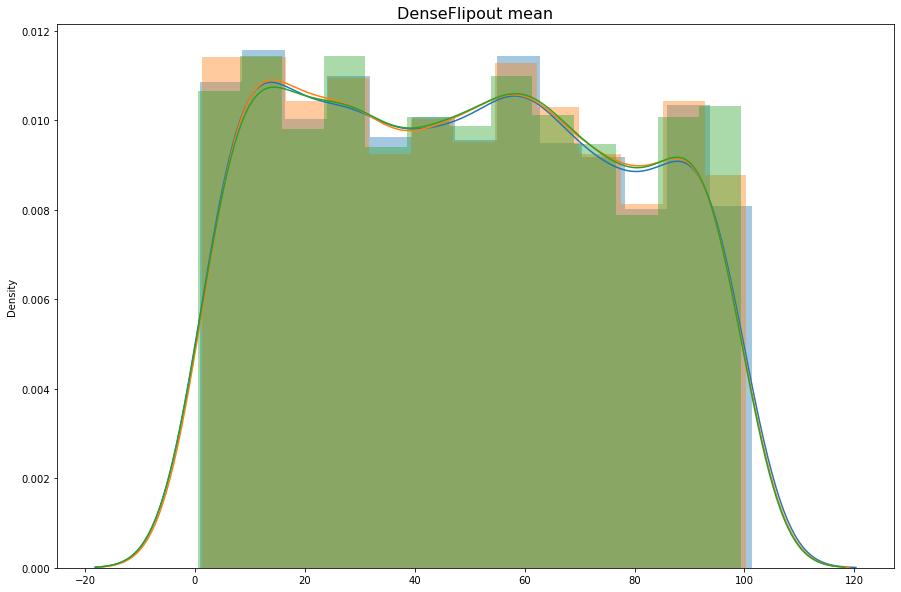

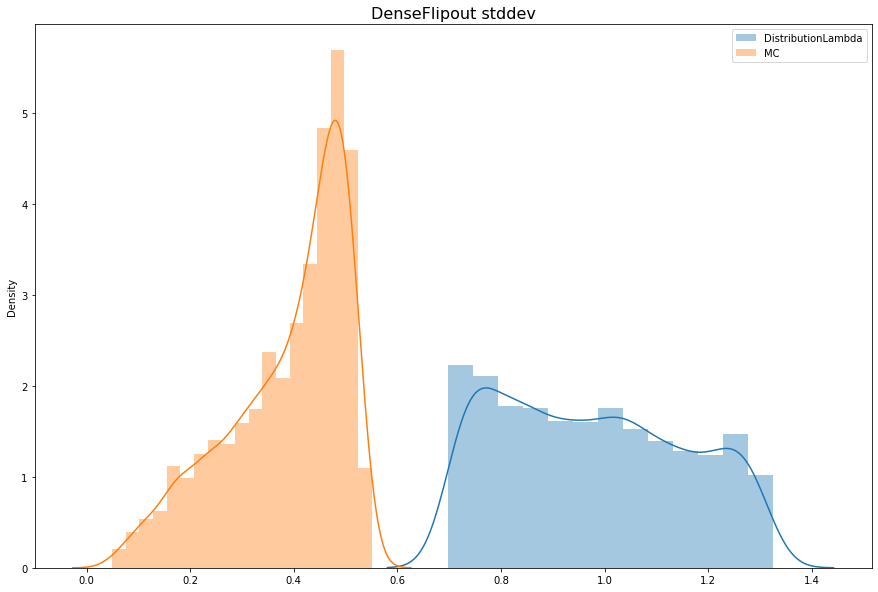

In [54]:
script.plot_distribution_mean_std(yhat=model(noisy_X_test[1]), predictions= pred, y_test= y_test)

## Noise 1.3

### Train Model Using Deterministic Loss Function

In [8]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

# Random searrch through choices
tuner_models = script.random_search(model= model1_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= noisy_X_train[2], 
                                    y_train= y_train,
                                    X_test= noisy_X_test[2], 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 3 Complete [00h 05m 53s]
val_loss: 1.5104116201400757

Best val_loss So Far: 1.5104116201400757
Total elapsed time: 00h 17m 50s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_noise_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.5104116201400757
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.7128301858901978
Trial summary
Hyperparameters:
loss_type: mape
Score: 3.2261459827423096
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 16)        304     

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [9]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=noisy_X_test[2])

(2000, 32, 32, 1)
(4, 2000)


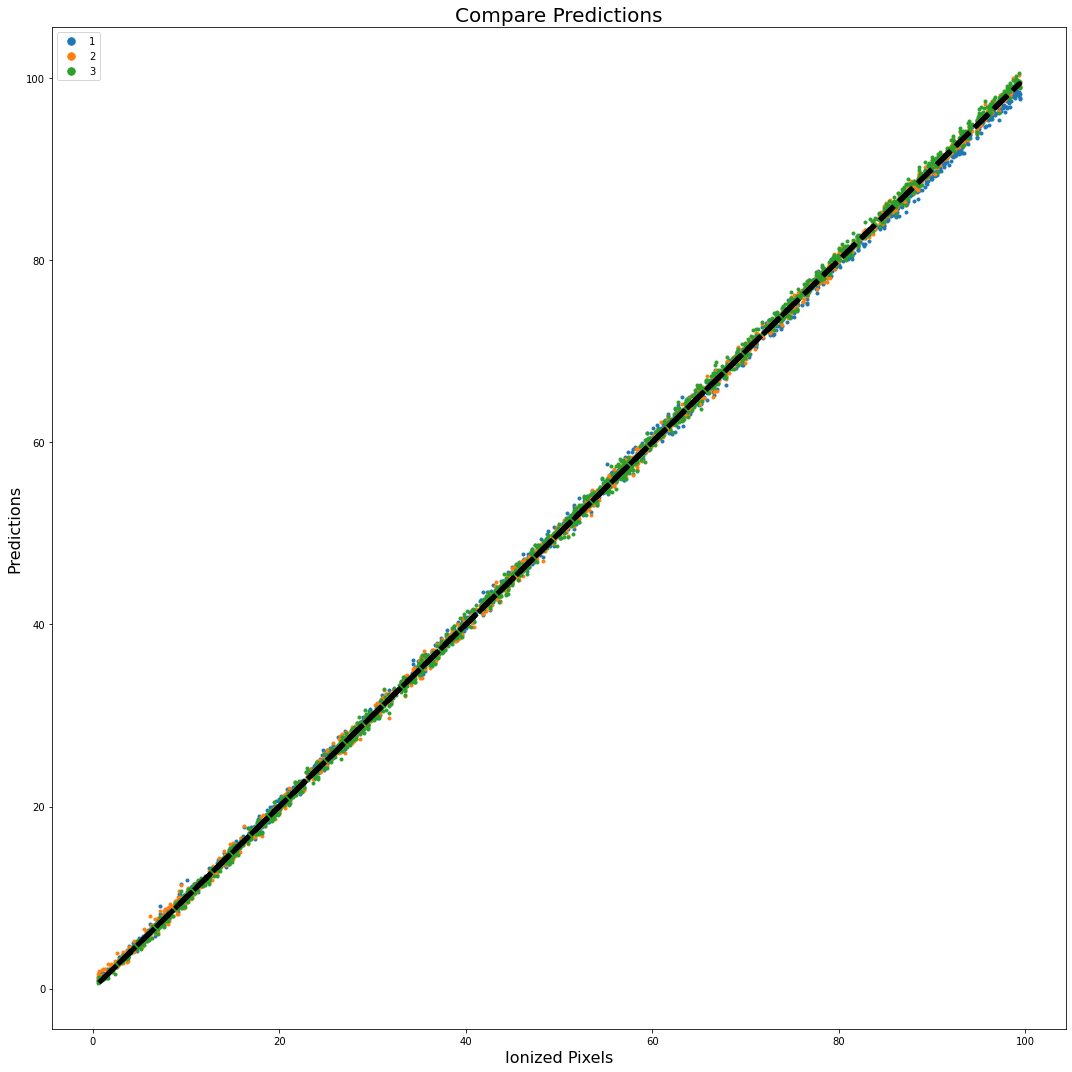

In [10]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions[1:,:])

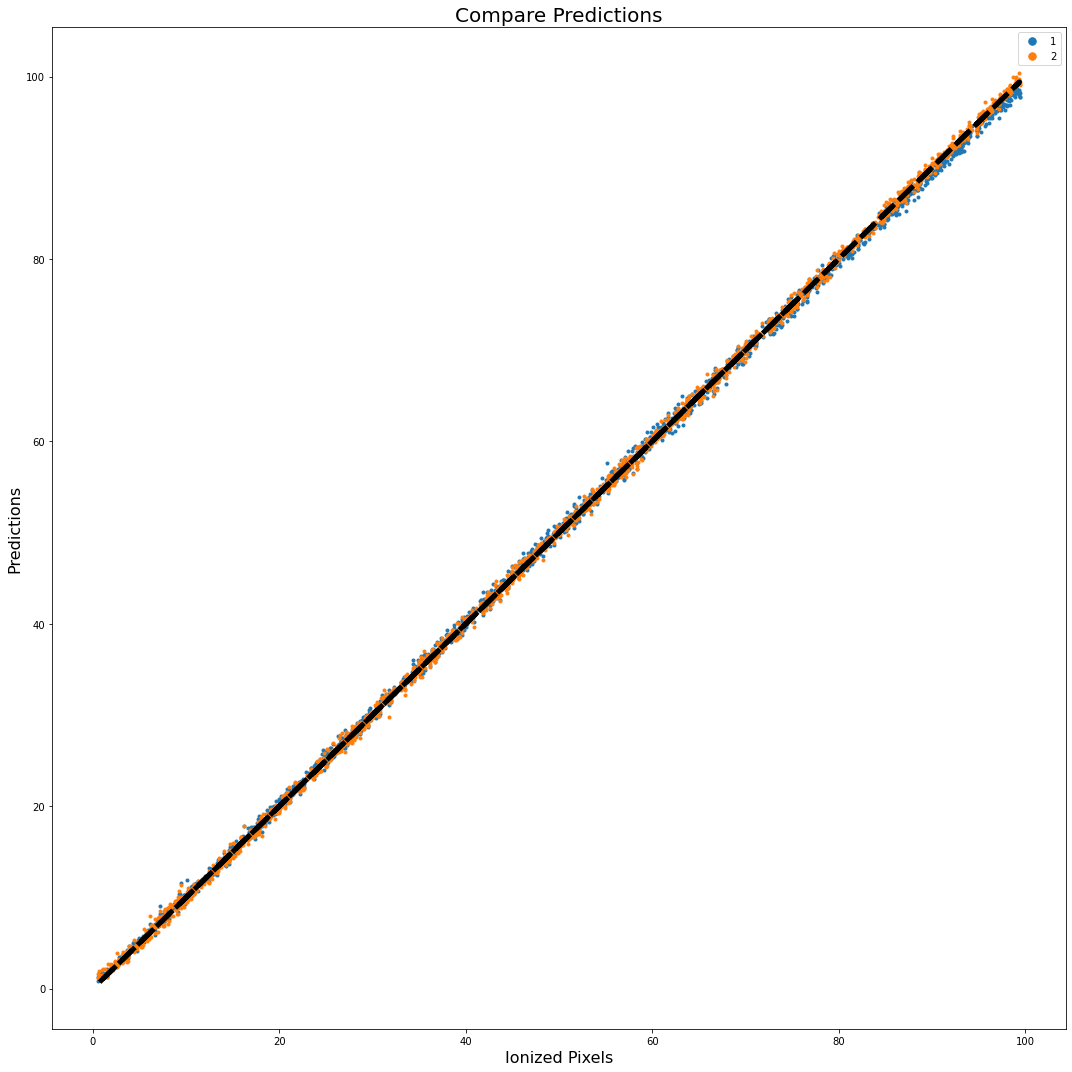

In [11]:
script.plot_one_to_one_pred(tuner_models= tuner_models[1:], y_test= y_test, predictions=predictions[1:,:])

In [12]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[1], X_test=noisy_X_test[2])


https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


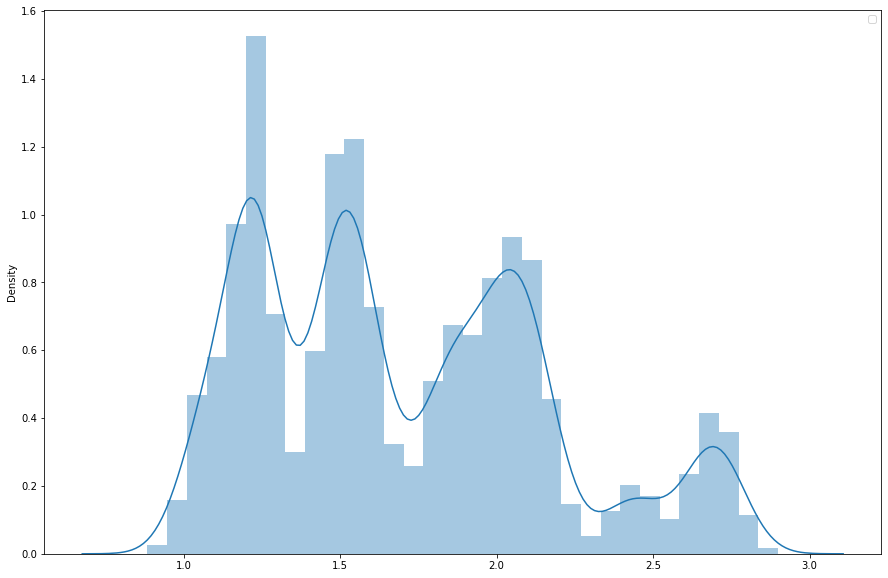

In [13]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

There's shifting...

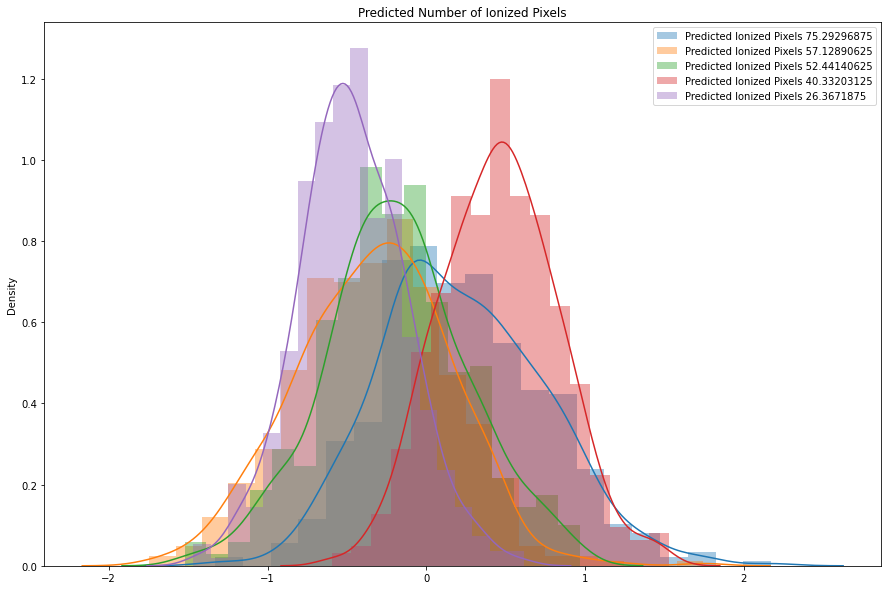

In [14]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

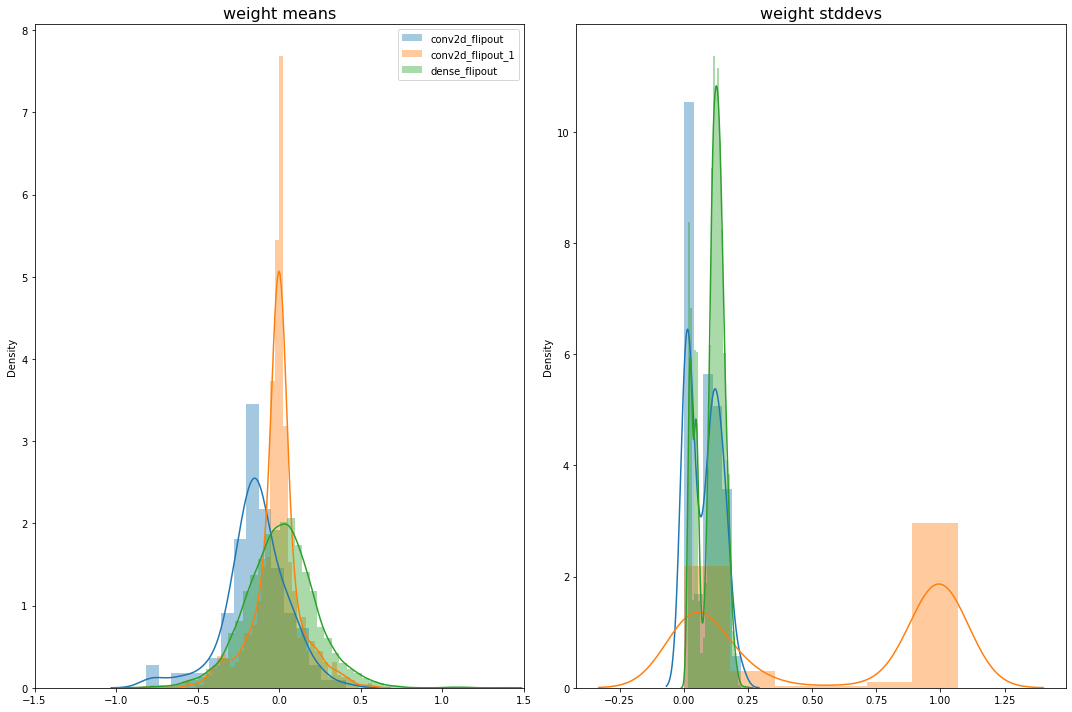

In [15]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-1])

### Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

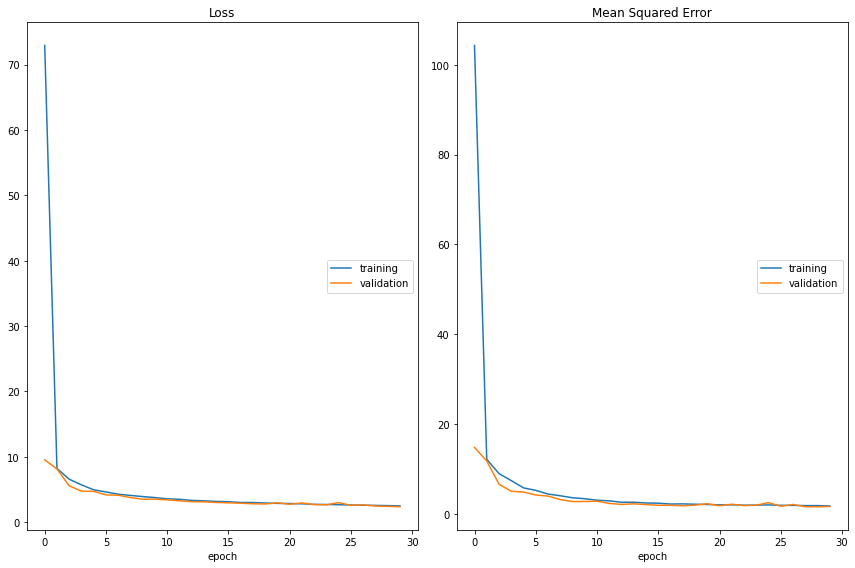

Loss
	training         	 (min:    2.483, max:   72.933, cur:    2.483)
	validation       	 (min:    2.359, max:    9.542, cur:    2.359)
Mean Squared Error
	training         	 (min:    1.735, max:  104.320, cur:    1.735)
	validation       	 (min:    1.568, max:   14.788, cur:    1.626)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 16)        304       
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 28, 28, 8)         2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 12545     
_________________________________________________________________
distribution_lambda (Distrib m

In [16]:
model = script.model1_ploss(X_train=noisy_X_train[2], y_train=y_train, 
                    X_test=noisy_X_test[2], y_test=y_test, nx=nx, ny=ny,
                    kl_divergence_function=kl_divergence_function,
                    epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE)

### Monte Carlo 

In [17]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=noisy_X_test[2])

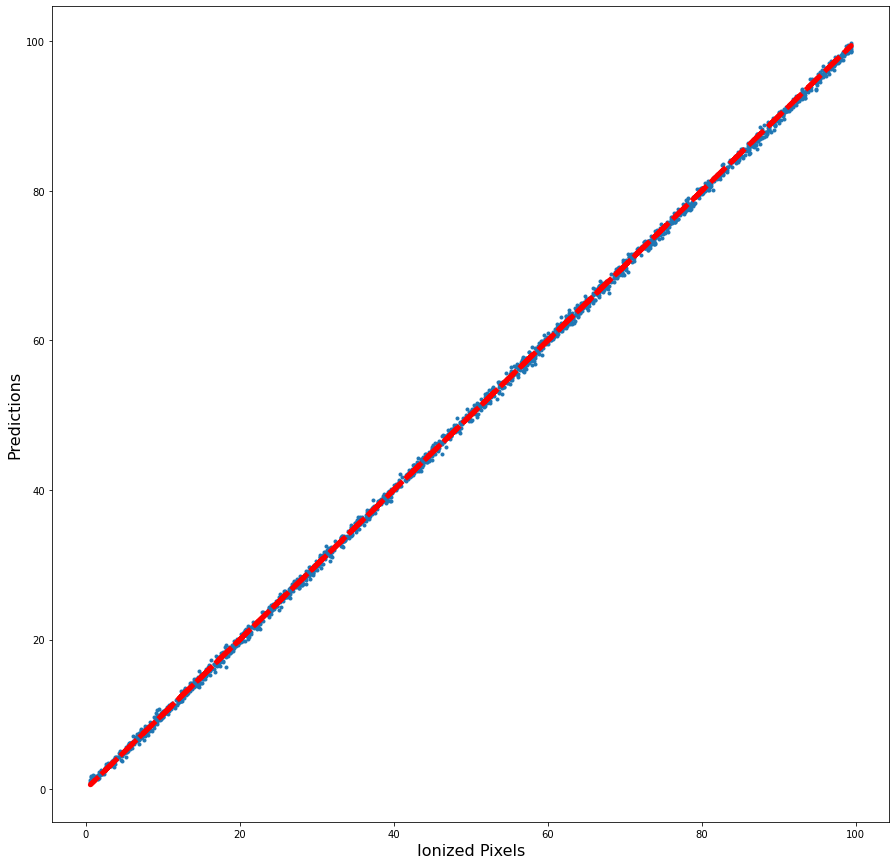

In [18]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

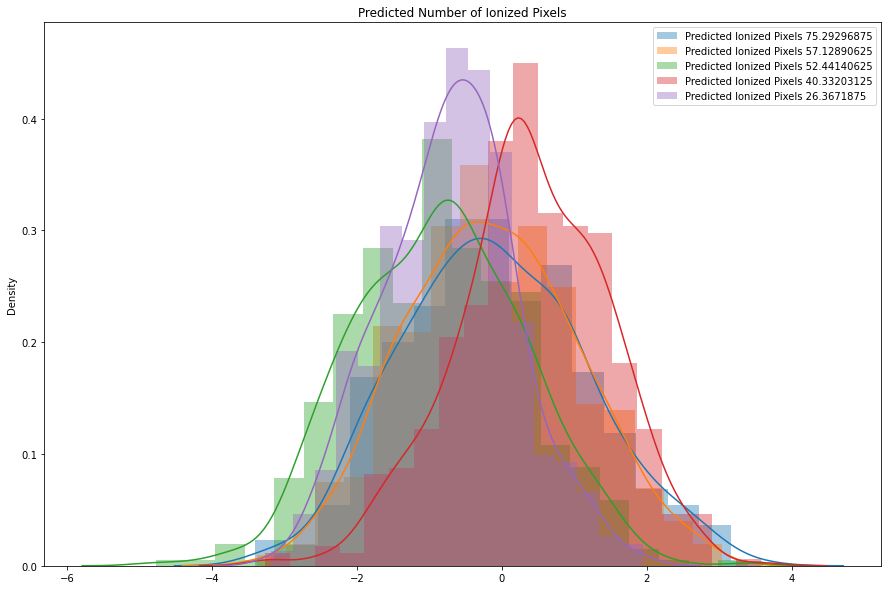

In [19]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


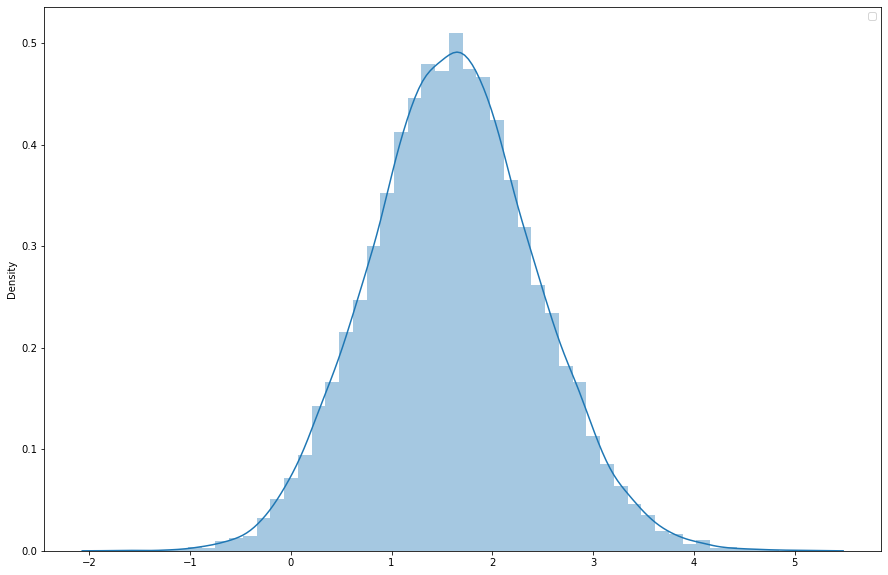

In [20]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


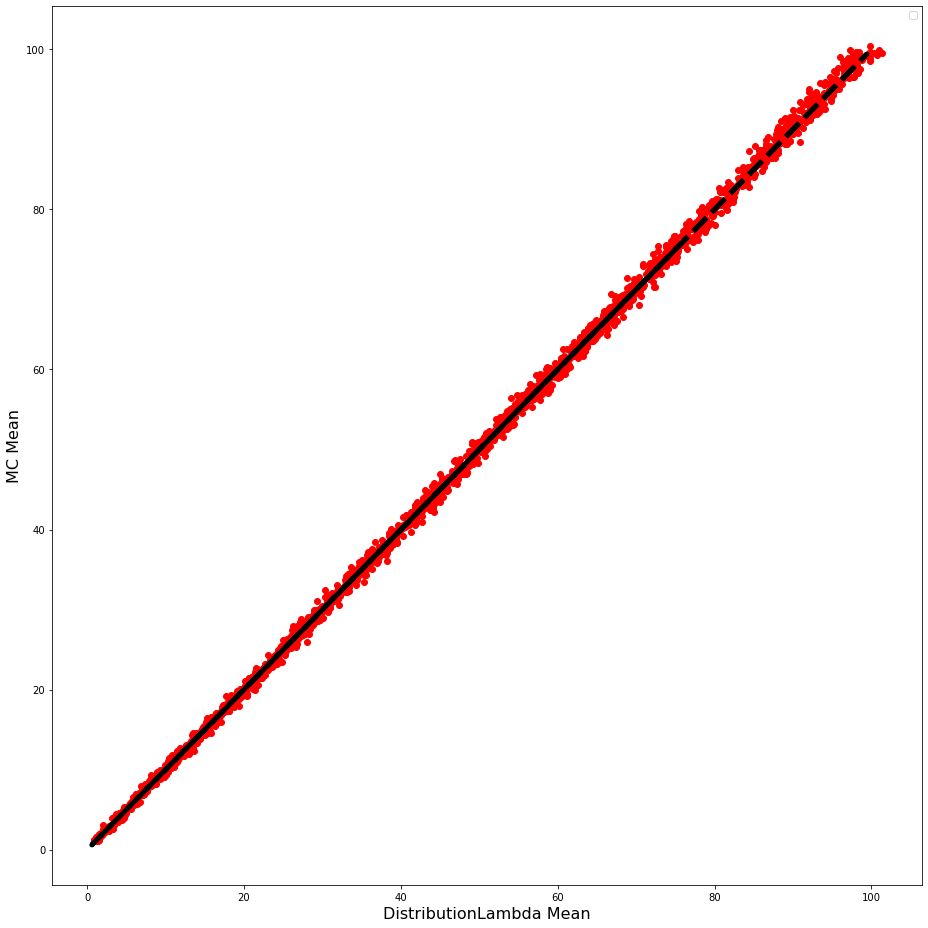

In [21]:
script.plot_compare_pred_values(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


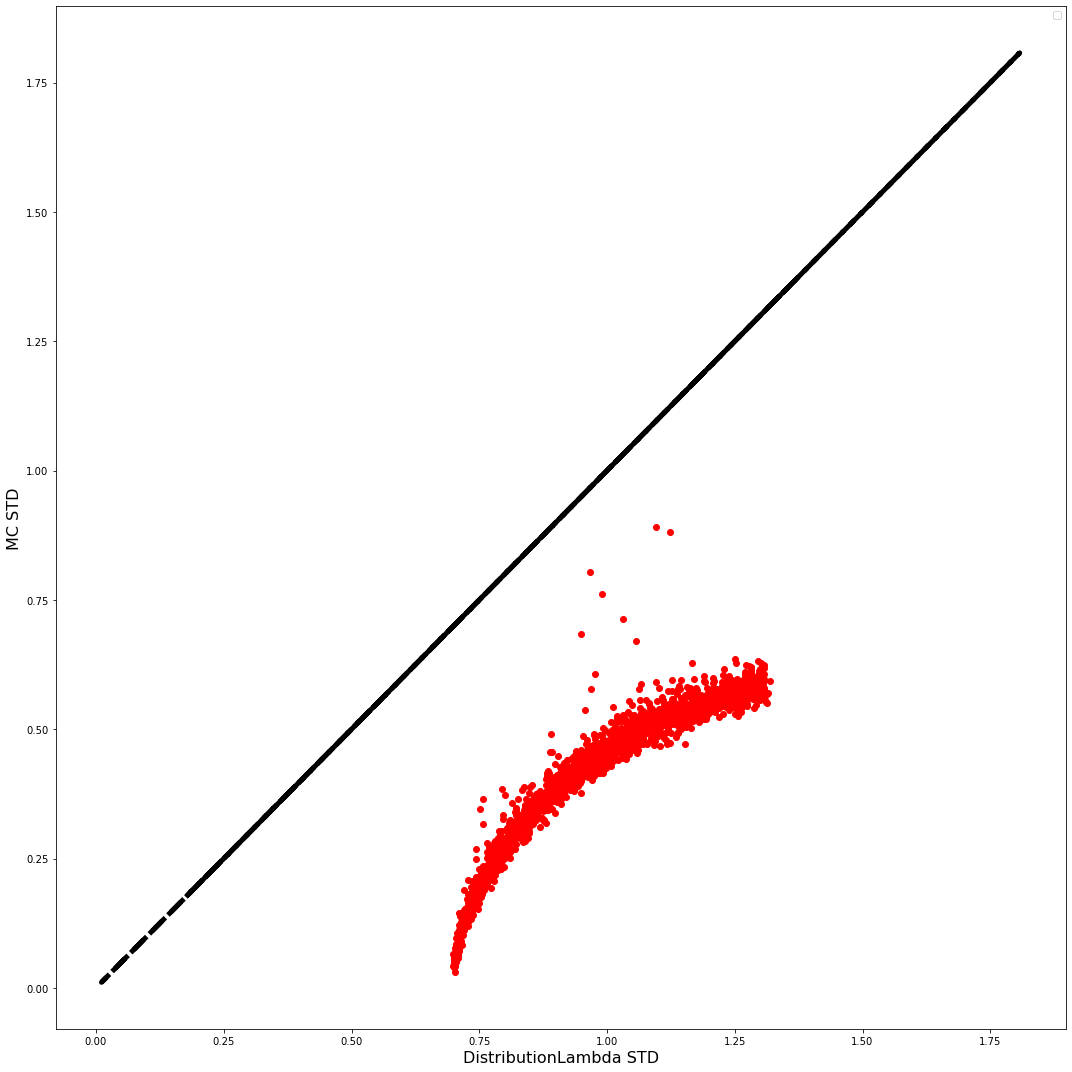

In [22]:
script.plot_compare_STDs(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

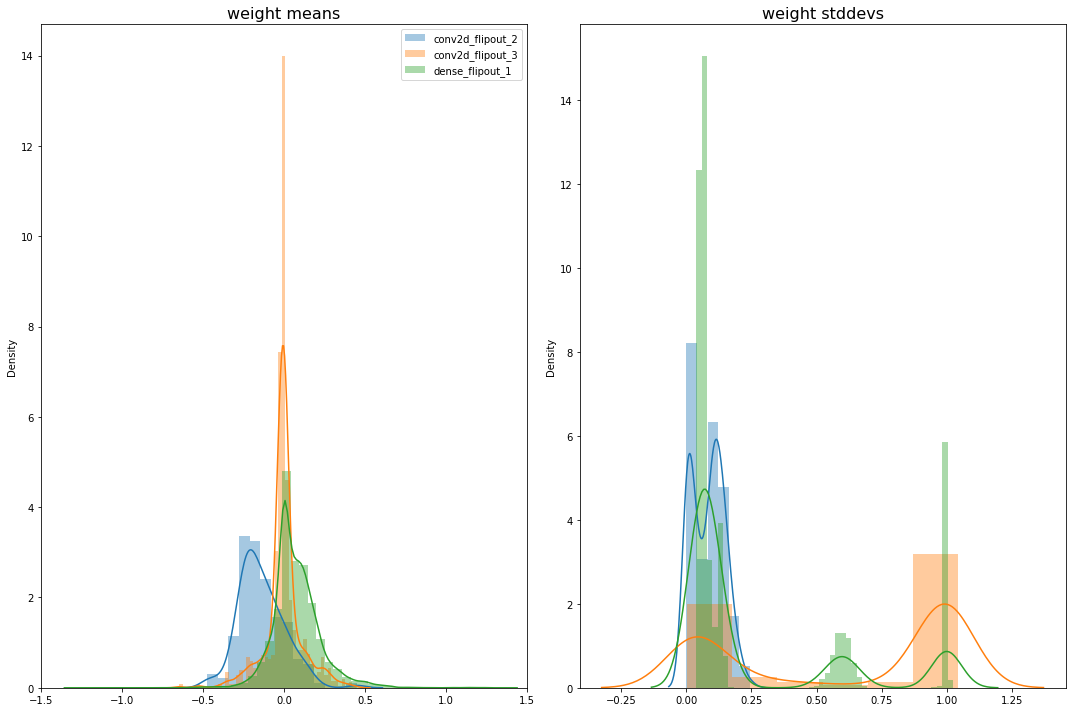

In [23]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [24]:
yhat = model(noisy_X_test[2]) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

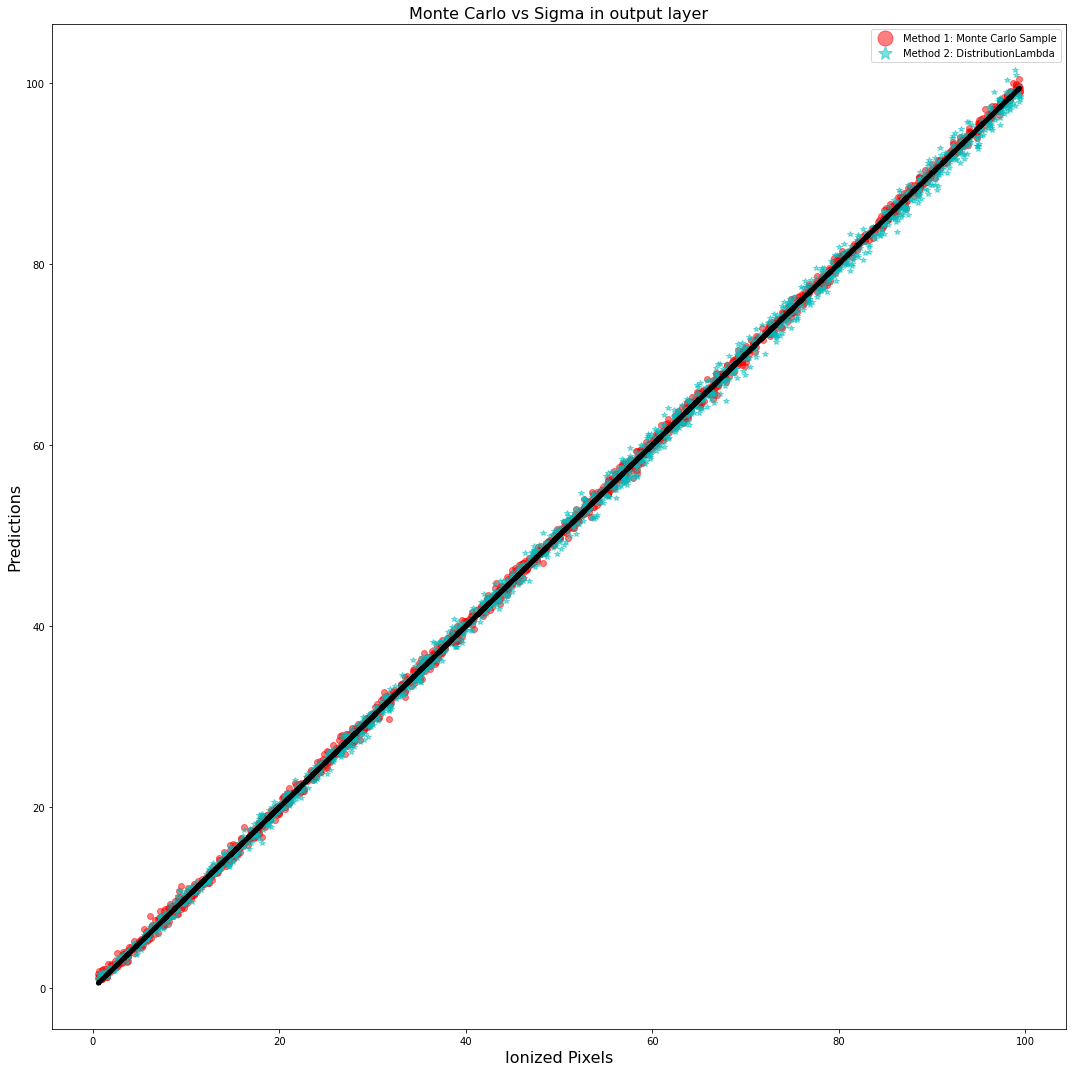

In [25]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

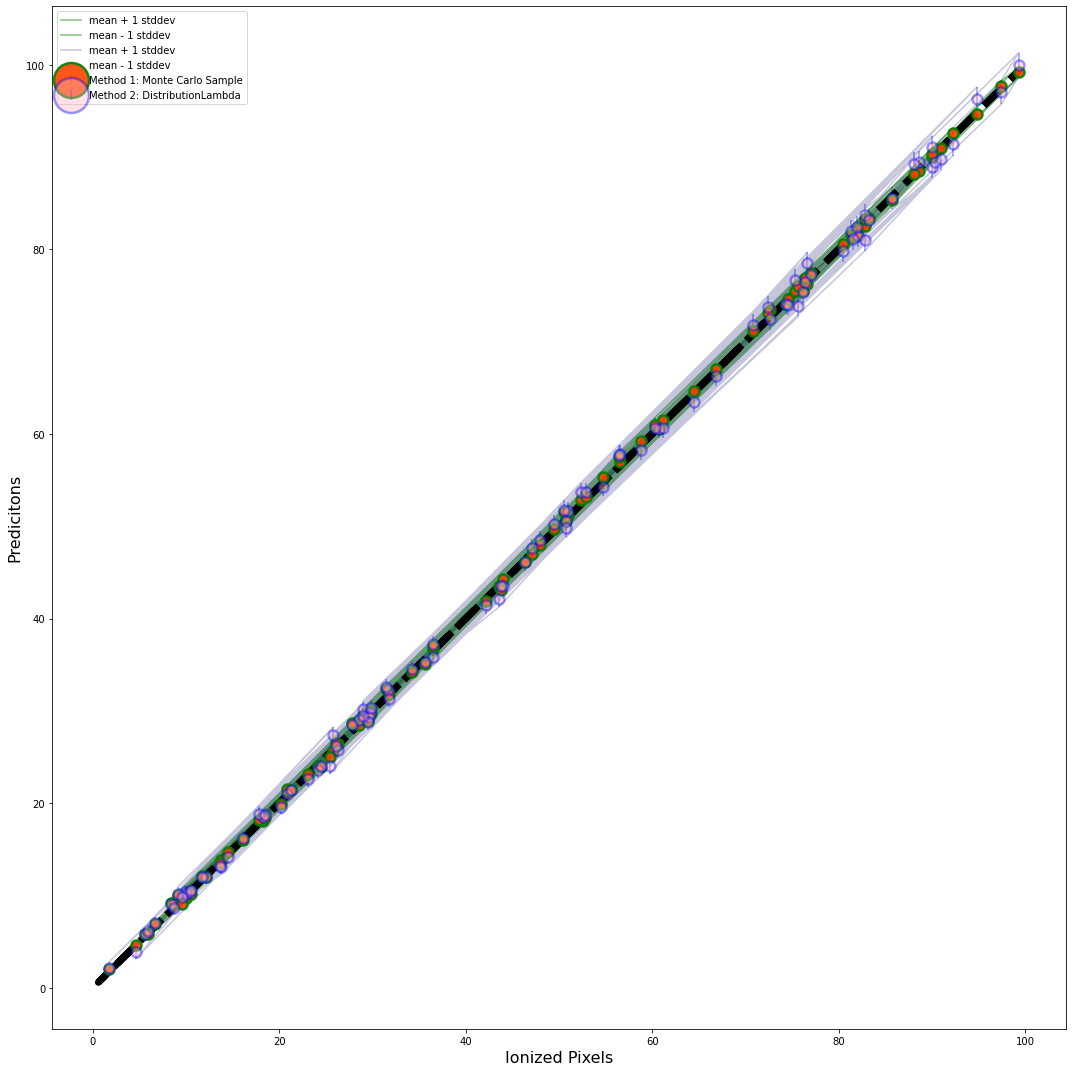

In [26]:
script.plot_error1(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)

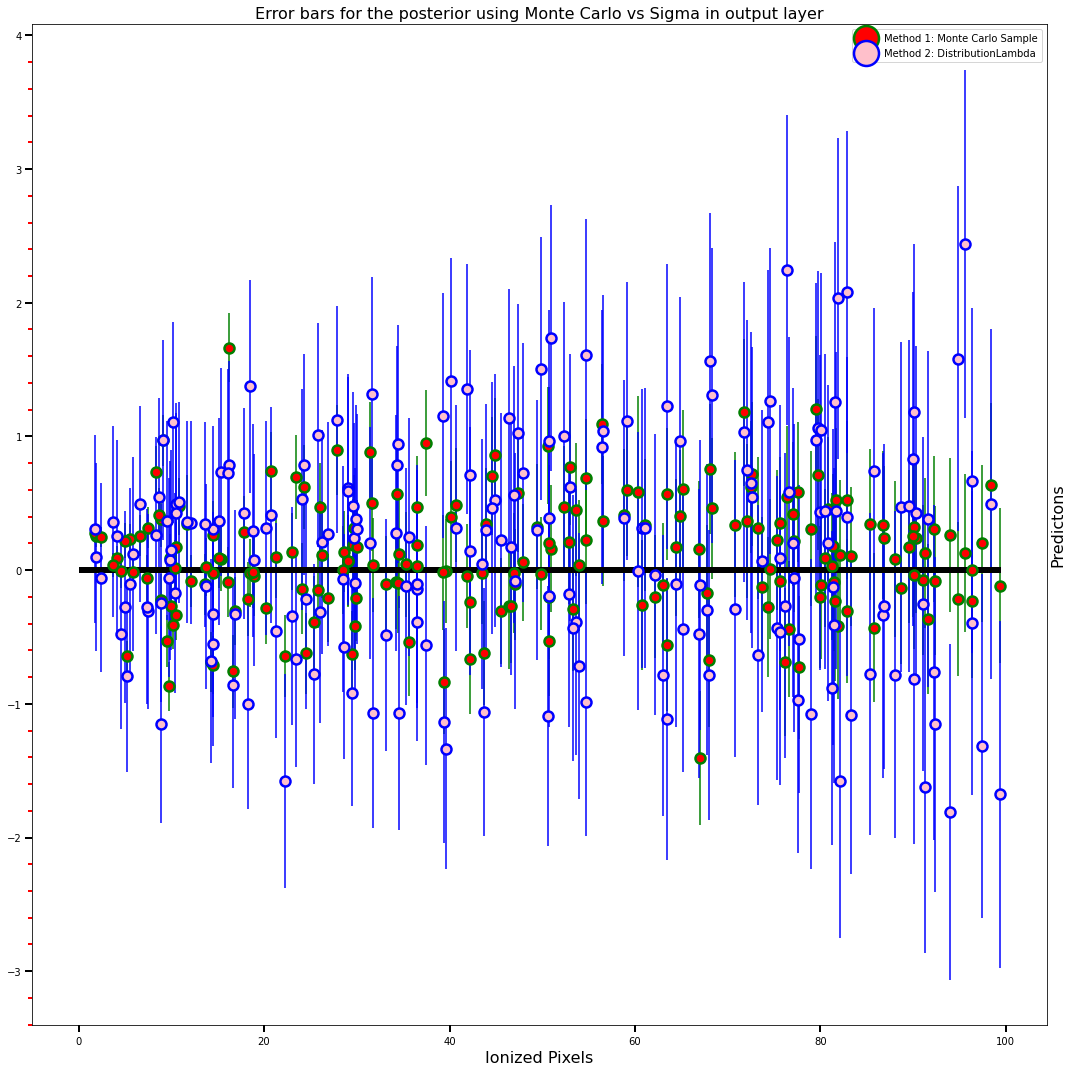

In [27]:
script.plot_error2(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)

The mean of the predictions using the DistributionLambda method is approximately uniform

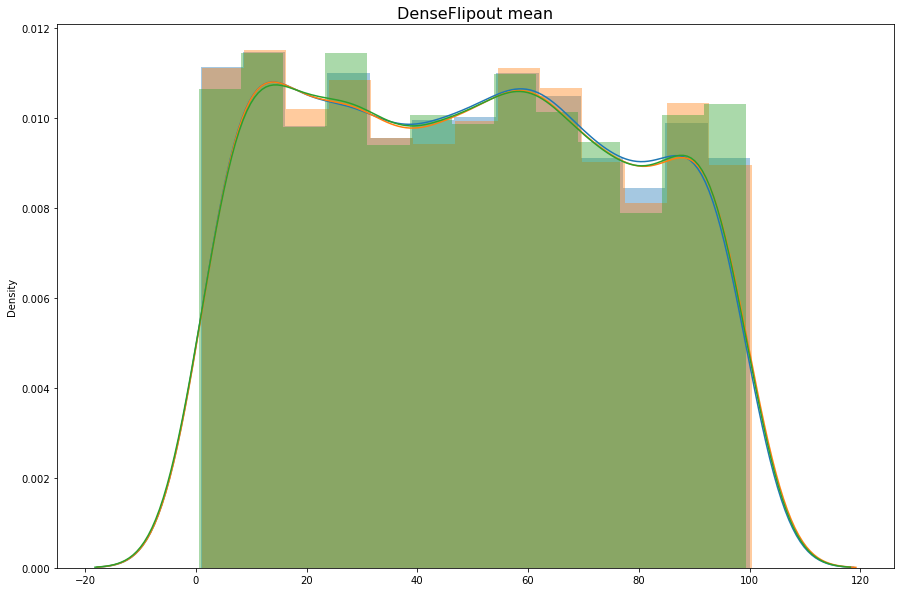

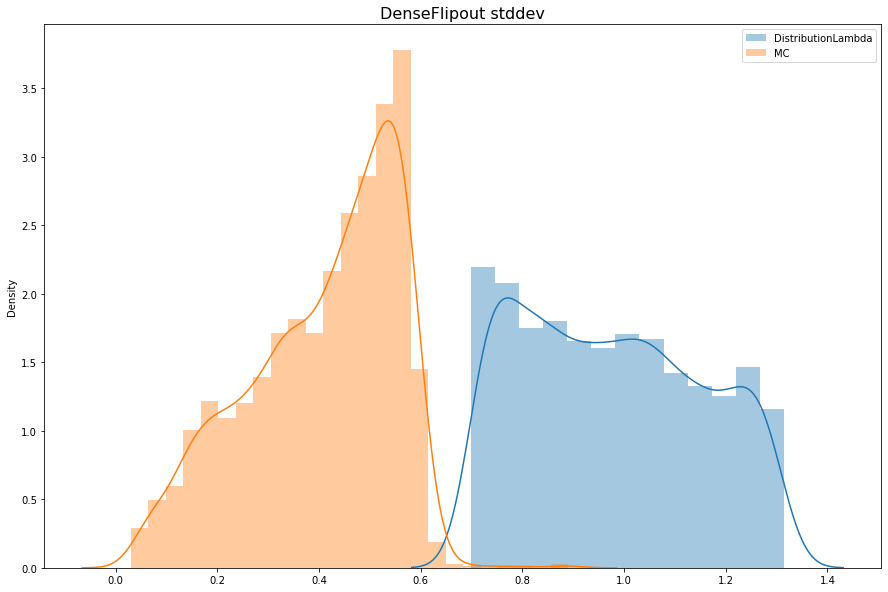

In [28]:
script.plot_distribution_mean_std(yhat=model(noisy_X_test[2]), predictions= pred, y_test= y_test)